In [8]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
import itertools as it
# import dadi 
# import dadi.DFE as DFE
from copy import deepcopy
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *
import os

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})
plt.style.use('bmh')

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## Analysis of complex demographic scenarios from PReFerSim

In this file, I will simulate changing population sizes and increase the level of complexity with each simulation. 

1. Bottleneck.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, 20k inds 10k gens ago, followed by 2k inds 2k gens ago)
`(https://github.com/dortegadelv/HaplotypeDFEStandingVariation/blob/master/Scripts/Sims/AncientBottleneck/ForwardSims/ParameterFile_4Ns-50.txt)`

In [2]:
## Need to create look-up tables matching the above demographic history...also run the gamma search over a relevant grid
gamma = -np.geomspace(1e-5,5e-3,20) #np.logspace(-0.5,2.5,25)
n = 1000
N = 10000
mu = 1.25e-8
cutoff = 2 # freq of 0.5%
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
# for N=10,000 & gamma=-10, s=-0.0005

In [3]:
# s = -np.array([8e-5]) # gamma of 2, 20, 200 for N=10,000 & 4Ns
# for ig, g in enumerate(s):
#     with open('simfiles/ParameterFilesBottleneck.txt',"r") as file:
#         data = file.readlines()

#     data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-g)
#     data[7] = 'FilePrefix: outfiles/Bottleneck{:.0e}\n'.format(-g)

#    with open('simfiles/ParameterFilesBottleneck.txt', 'w') as file:
#        file.writelines(data)
        
#     os.system("GSL_RNG_SEED=1004 GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesBottleneck.txt 1")

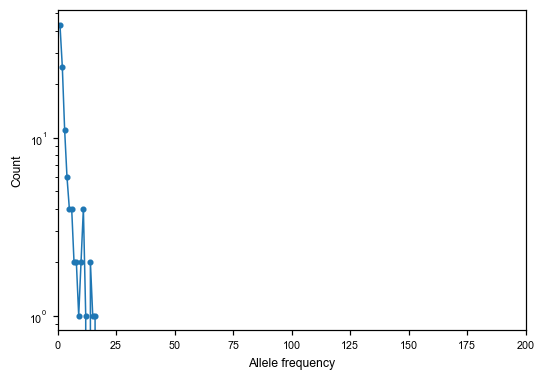

In [1241]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/Bottleneck8e-03.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
Nc = np.concatenate((np.repeat(20000,80000),np.repeat(2000,2000)))
nu_func = lambda t: [Nc[int(t*Nc[0])]/Nc[0]]
df1['sXl'] = df1['Xl']*200 
df1['al'] = len(Nc)+1 - df1['al']
dat = df1.to_numpy(dtype='int64')
# plt.hist(df1['sXl'],50); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
# plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

sfs = moments.Spectrum(np.histogram(df1['sXl'],bins=range(0,202))[0])
moments.Plotting.plot_1d_fs(sfs)

SMS = np.zeros((len(Nc),200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

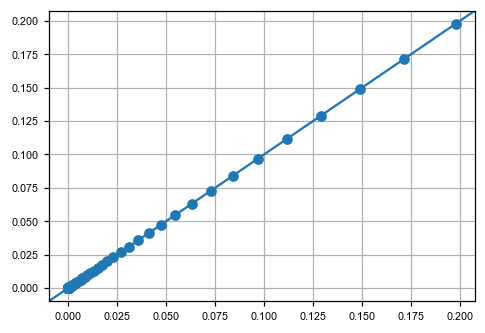

In [528]:
## CODE TO SHOW 1:1 RELATIONSHIP B/W MOMENTS & MY CALCULATIONS FOR *CHANGING POP SIZE*
# fs = moments.Spectrum(np.zeros(201)); fs[1] = 500
# fs.integrate(nu_func, 5000*4.1/len(Nc), gamma=-2*8, dt_fac=0.0005, theta=0)
# moments.Plotting.plot_1d_fs(fs)

# fsa = run_mom_iterate_changing(200, -16/10000, Nc/2, 500, {})

## plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar();

# plt.scatter(fs,fsa[-5000]); plt.axline((0,0),slope=1); plt.grid(); #plt.loglog()

# plt.plot(Nc[::-1]/Nc[0]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
# plt.plot([nu_func(t) for t in np.linspace(4.095,0,82000)]) ## 10,000 gens is 0.5

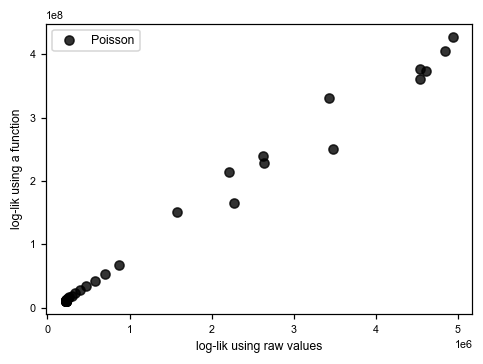

In [86]:
# llfreq = [np.sum(get_lp_xl(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
# llfreqpois = [np.sum(get_lp_xl_pois(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
# llfreqbin = [np.sum(get_lp_xl_bin(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
plt.scatter(llfreq, llfreqpois, color='k', alpha=0.8, label='Poisson'); plt.xlabel('log-lik using raw values'); plt.ylabel('log-lik using a function'); plt.legend()

2. Expansion.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of recent expansion 200 gens ago to 200k inds 

In [169]:
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
s = -np.array([2.5e-5,2.5e-4,2.5e-3,8e-5,8e-4]) # gamma of 2, 20, 200 for N=10000 & 4Ns
for ig, g in enumerate(s):
    with open('simfiles/ParameterFilesExpansion.txt',"r") as file:
        data = file.readlines()

    data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-g)
    data[7] = 'FilePrefix: outfiles/Expansion{:.0e}\n'.format(-g)

    with open('simfiles/ParameterFilesExpansion.txt', 'w') as file:
        file.writelines(data)
        
    os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesExpansion.txt 3".format(rng.integers(100496)))

GSL_RNG_TYPE=mrg
GSL_RNG_SEED=36520



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000025
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-05

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16006078

Total number of mutations = 20005374


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=50361
GSL_RNG_TYPE=mrg
GSL_RNG_SEED=59200



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.002500
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-03

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 15997875

Total number of mutations = 19997401


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=4624



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000080
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion8e-05

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16002395

Total number of mutations = 20002639


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=88220



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000800
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion8e-04

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16003032

Total number of mutations = 20002072


In [1247]:
# gamma = -np.logspace(-0.5,2.5,30)
# 2 contains the 4x expansion from 10k to 40k, 3 contains the 10x expansion from 5k to 50k
# df1 = pd.read_csv("outfiles/Expansion8e-04.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
# Nc = np.concatenate((np.repeat(10000,50000),np.repeat(40000,5000)))
Nc = np.concatenate((np.repeat(5000,20000),np.repeat(50000,2000)))
nu_func = lambda t: [Nc[int(t*Nc[0])]/Nc[0]]
# df1['sXl'] = df1['Xl']*200
# df1['al'] = len(Nc)+1 - df1['al']
# dat = df1.to_numpy(dtype='int64')
# plt.hist(df1['sXl'],10); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],15); plt.xlabel('age of allele'); plt.show()
# plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

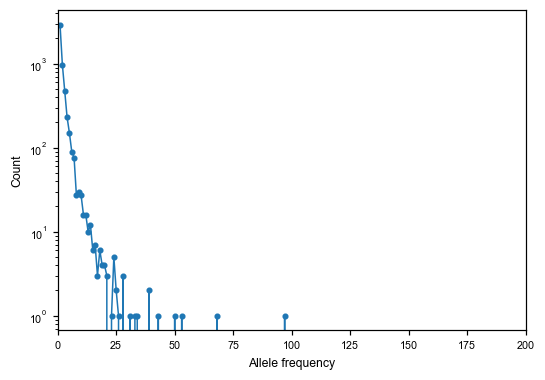

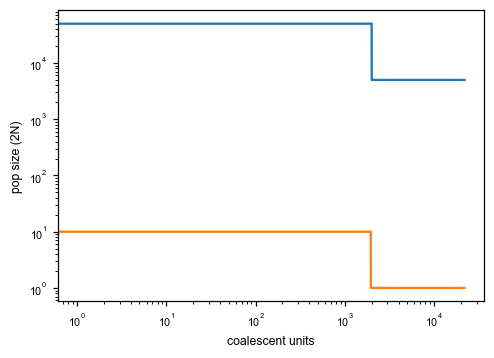

In [723]:
sfs = moments.Spectrum(np.histogram(df1['sXl'],bins=range(0,202))[0])
moments.Plotting.plot_1d_fs(sfs)

SMS = np.zeros((len(Nc),200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

plt.plot(Nc[::-1]); plt.loglog(); plt.xlabel('gens ago'); plt.ylabel('pop size (2N)');
plt.plot([nu_func(t) for t in np.linspace(4.39,0,len(Nc))]); plt.loglog(); plt.xlabel('coalescent units'); 

In [730]:
# sp.optimize.minimize_scalar(get_ll_freqdemchanging,args=({'nu':nu_func,'T':4.39,'sfs':sfs,'p_misid':0,'theta':400},200),)
# get_ll_freqdemchanging(np.log10(1),{'nu':nu_func,'T':4.39,'sfs':sfs,'p_misid':0,'theta':400},200)

# sp.optimize.minimize_scalar(get_ll_freqagedemchanging,args=({'nu':nu_func,'Nc':Nc,'sms':SMSmask,'p_misid':0,'theta':2},200))
# get_ll_freqagedemchanging(np.log10(0.2),{'nu':nu_func,'Nc':Nc,'sms':SMSmask,'p_misid':0,'theta':2},200)

23800.092

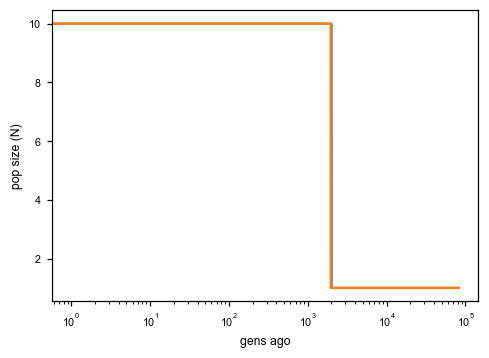

In [182]:
plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
plt.plot([nu_func(t) for t in np.linspace(16.39,0,82000)]) # should align on top of real demography if unscaled by Nc[0]
# plt.imshow(up_xa_s[gamma[-1]],aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar()

In [125]:
estfreq, estage = np.array([2.67, 9.87, 26.33, 97.43, 259.9])*1e-5, np.array([1.0, 5.131, 13.69, 70.25, 259.9])*1e-5
sefreq, seage = np.array([4.544, 2., 2.764, 10.44, 47.11])*1e-5, np.array([3.022, 1.62, 3.3, 9.79, 45.15])*1e-5
trues = np.array([1,3.2,10,32,100])*2.5e-5

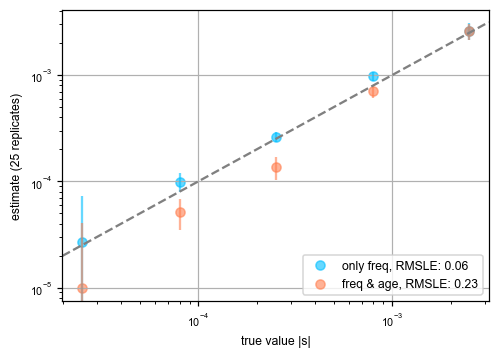

In [126]:
## plotting truth vs mean + CI estimates 
plt.scatter(trues,estfreq,color='deepskyblue',alpha=0.6,label='only freq, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(trues)-np.log10(estfreq))**2)))); 
plt.scatter(trues,estage,color='coral',alpha=0.6,label='freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(trues)-np.log10(estage))**2)))); plt.legend(loc='lower right')
plt.errorbar(trues,estfreq,yerr=sefreq,color='deepskyblue',ls='none',alpha=0.6); plt.xlabel('true value |s|')
plt.errorbar(trues,estage,yerr=seage,color='coral',ls='none',alpha=0.6); plt.ylabel('estimate (25 replicates)')
plt.loglog(); plt.axline((0,0),(1e-3,1e-3),color='grey',linestyle='--'); plt.grid()

-1.0
-1.0


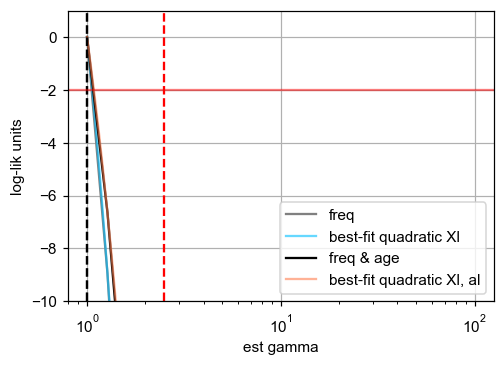

In [ ]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'].iloc[0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

3. BottleneckpExpenasion.txt with point prob selection coefficient () and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, followed by exponential growth)

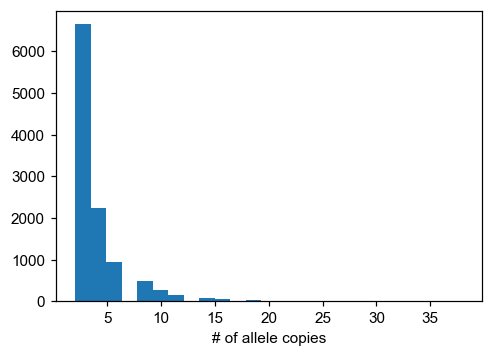

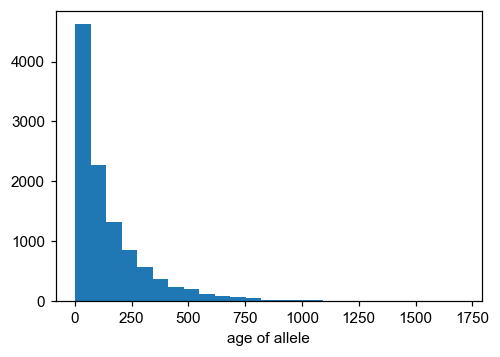

[]

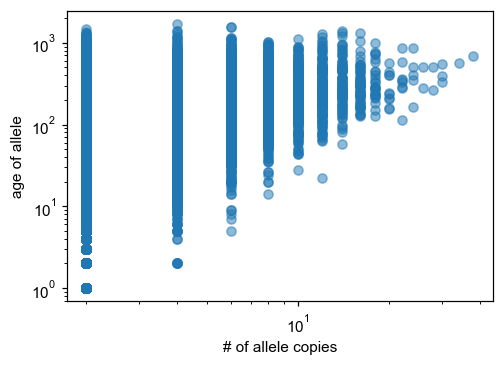

In [ ]:
df1 = pd.read_csv("PReFerSims/outfiles/BottleneckpExpansion10.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
Nc = np.concatenate((np.repeat(10000,50000),np.repeat(2000,500),np.repeat(50000,3000)))/2
df1['sXl'] = df1['Xl']*n #rng.binomial(n=n, p=df1['Xl'])
df1['al'] = len(Nc)+1 - df1['al']
df1 
dat = df1.sample(frac=0.9).to_numpy(dtype='int64')
plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

In [ ]:
mle = get_boot_ci(gamma[:-1],p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=50,cutoff=2)
mle.mean(axis=0), mle.std(axis=0)

(array([-249.202, -126.549]), array([0.000, 11.382]))

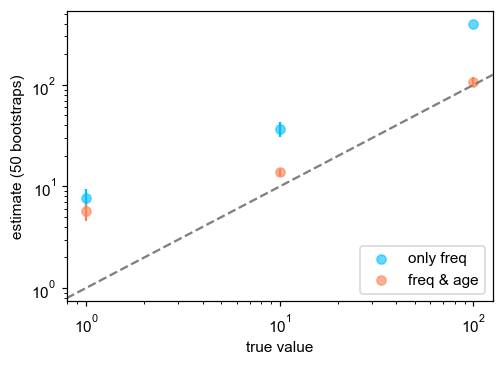

In [ ]:
## plotting truth vs mean + CI estimates 
plt.scatter([1.,10.,100.],[7.69,37.2,400],color='deepskyblue',alpha=0.6,label='only freq')
plt.scatter([1.,10.,100.],[5.69,13.8,107.5],color='coral',alpha=0.6,label='freq & age'); plt.legend(loc='lower right')
plt.errorbar([1.,10.,100.],[7.69,37.2,400],yerr=[1.7,6.2,0],color='deepskyblue',ls='none'); plt.xlabel('true value')
plt.errorbar([1.,10.,100.],[5.69,13.8,107.5],yerr=[1.1,1.1,12.8],color='coral',ls='none'); plt.ylabel('estimate (50 bootstraps)')
plt.loglog(); plt.axline((1,1),(100,100),color='grey',linestyle='--')

### Following manual from moments with Mende from Sierra Leone (MSL, 1000G) data 
#### (checking to see if we get similar DFE)

In [3]:
import pickle 
data = pickle.load(open("../testdata/sampleData/msl_data.bp", "rb"))

fs_syn = data["spectra"]["syn"]
fs_mis = data["spectra"]["mis"]
fs_lof = data["spectra"]["lof"]

u_syn = data["rates"]["syn"]
u_mis = data["rates"]["mis"]
u_lof = data["rates"]["lof"]

print("Diversity:")
print(f"synonymous:\t{fs_syn.pi():.2f}")
print(f"missense:\t{fs_mis.pi():.2f}")
print(f"loss of func:\t{fs_lof.pi():.2f}")

print()
print("Diversity scaled by total mutation rate:")
print(f"synonymous:\t{fs_syn.pi() / u_syn:.2f}")
print(f"missense:\t{fs_mis.pi() / u_mis:.2f}")
print(f"loss of func:\t{fs_lof.pi() / u_lof:.2f}")

Exception ignored in: <_io.FileIO name='../testdata/sampleData/msl_data.bp' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_79019/422844747.py", line 2, in <module>


Diversity:
synonymous:	8452.01
missense:	6991.16
loss of func:	95.16

Diversity scaled by total mutation rate:
synonymous:	58614.15
missense:	20408.81
loss of func:	3718.19


In [4]:
def model_func(params, ns):
    nuA, nuF, TA, TF, p_misid = params
    fs = moments.Demographics1D.snm(ns)
    fs.integrate([nuA], TA)
    nu_func = lambda t: [nuA * np.exp(np.log(nuF / nuA) * t / TF)]
    fs.integrate(nu_func, TF)
    return (1-p_misid) * fs + p_misid * fs[::-1]

p_guess = [2.0, 10.0, 0.3, 0.01, .02]
lower_bound = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3]
upper_bound = [10, 100, 1, 1, 1-1e-3]

opt_params = moments.Inference.optimize_log_fmin(
    p_guess, fs_syn, model_func,
    lower_bound=lower_bound, upper_bound=upper_bound)

model = model_func(opt_params, fs_syn.sample_sizes)
opt_theta = moments.Inference.optimal_sfs_scaling(model, fs_syn)
Ne = opt_theta / u_syn / 4

print("optimal demog. parameters:", opt_params)
print("inferred Ne:", f"{Ne:.2f}")

optimal demog. parameters: [2.215 5.298 0.555 0.041 0.020]
inferred Ne: 11372.91


In [250]:
# np.arange(opt_params[2],opt_params[3]+opt_params[2],0.5/Ne)
opt_params[2]+opt_params[3]

0.5953820251775782

In [350]:
## code to construct demography for a constant + continuous expansion/decline phase
## add an extra burn-in period of 3(?) coalescent time units up front to achieve equilibrium
# burnin = 3
# Nc_mis = []
# Nc_mis.append(np.repeat(opt_params[0]*2*Ne,int((burnin+opt_params[2])*2*Ne)))
# Nc_mis = Nc_mis[0].tolist()
# [Nc_mis.append((opt_params[0]*np.exp(np.log(opt_params[1]/opt_params[0])*(t-(opt_params[2]+burnin))/opt_params[3]))*2*Ne) for t in np.arange(burnin+opt_params[2],burnin+opt_params[3]+opt_params[2],0.5/Ne)]
# Nc_mis = np.array(Nc_mis)
# nu_func_mis = lambda t: [Nc_mis[int(t*2*Ne)]/Ne] # Nc[0] = Ne
# plt.plot(Nc_mis[::-1]/1e5); plt.semilogx(); plt.xlabel('time in gens'); plt.ylabel('pop size in 10k inds')
Nc_mis
# Nc = np.array(list(it.chain(*Nc)))

array([50389.182, 50389.182, 50389.182, ..., 120176.827, 120289.561,
       120402.402])

In [5]:
## creating a demographic function that contains the same pop sizes as above
# len(data['spectra']['mis'])
dat = np.zeros((int(np.sum(fs_mis[1:-1])),6),dtype='int')
ctr = 0
for ix in range(1,len(fs_mis)-1):
    dat[ctr:(ctr+int(fs_mis[ix])),5] = ix
    dat[ctr:(ctr+int(fs_mis[ix])),3] = np.exp(rng.normal(1.163*np.log(ix)+4.9,0.25,int(fs_mis[ix])))
    ctr += int(fs_mis[ix])

dat[dat[:,3]>80000,3] = 80000

[]

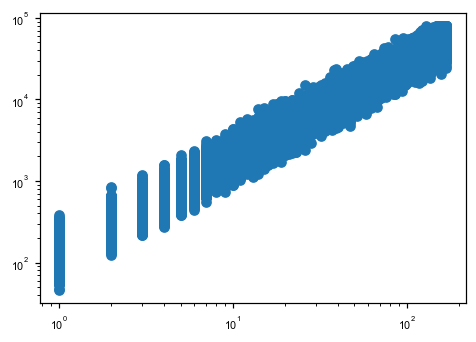

In [154]:
# rng.random.normal(1.163*np.log(25)+4.9,2,10)
# ctr:(ctr+int(fs_mis[ix])

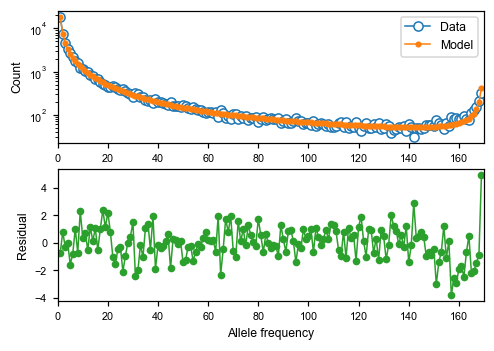

In [6]:
moments.Plotting.plot_1d_comp_multinom(model, fs_syn, residual="linear")

def selection_spectrum(gamma, h=0.5):
    rerun = True
    ns_sim = 100
    while rerun:
        ns_sim = 2 * ns_sim
        fs = moments.LinearSystem_1D.steady_state_1D(ns_sim, gamma=gamma, h=h)
        fs = moments.Spectrum(fs)
        fs.integrate([opt_params[0]], opt_params[2], gamma=gamma, h=h)
        nu_func = lambda t: [opt_params[0] * np.exp(
            np.log(opt_params[1] / opt_params[0]) * t / opt_params[3])]
        fs.integrate(nu_func, opt_params[3], gamma=gamma, h=h)
        if abs(np.max(fs)) > 10 or np.any(np.isnan(fs)):
            # large gamma-values can require large sample sizes for stability
            rerun = True
        else:
            rerun = False
    fs = fs.project(fs_syn.sample_sizes)
    fs[fs<0] = -fs[fs<0]
    return fs

spectrum_cache = {}
spectrum_cache[0] = selection_spectrum(0)

gammas = np.logspace(-3, 3, 30)
for gamma in gammas:
    spectrum_cache[gamma] = selection_spectrum(-gamma)

In [7]:
theta_mis = opt_theta * u_mis / u_syn

dxs = ((gammas - np.concatenate(([gammas[0]], gammas))[:-1]) / 2
    + (np.concatenate((gammas, [gammas[-1]]))[1:] - gammas) / 2)

def dfe_func(params, ns, theta=1):
    alpha, beta = params
    fs = spectrum_cache[0] * sp.stats.gamma.cdf(gammas[0], alpha, scale=beta)
    weights = sp.stats.gamma.pdf(gammas, alpha, scale=beta)
    for gamma, dx, w in zip(gammas, dxs, weights):
        fs += spectrum_cache[gamma] * dx * w
    fs = theta * fs
    return (1 - 0.0137) * fs + 0.0137 * fs[::-1]

def model_func_missense(params, ns):
    return dfe_func(params, ns, theta=theta_mis)

p_guess = [0.5, 10000]
lower_bound = [1e-4, 1e-1]
upper_bound = [1e1, 1e5]

opt_params_mis = moments.Inference.optimize_log_fmin(
    p_guess, fs_mis, model_func_missense,
    lower_bound=lower_bound, upper_bound=upper_bound,
    multinom=False)

model_mis = model_func_missense(opt_params_mis, fs_mis.sample_sizes)
print("optimal parameters:")
print("shape:", f"{opt_params_mis[0]:.4f}")
print("scale:", f"{opt_params_mis[1]:.1f}")
print("Log-likelihood:", moments.Inference.ll_multinom(model_mis, fs_mis))

optimal parameters:
shape: 0.1591
scale: 2466.4
Log-likelihood: -695.1244578923452


In [874]:
# np.sum(-model_mis.data + fs_mis.data*model.log() - sp.special.gammaln(fs_mis + 1.)), moments.Inference.ll_multinom(model_mis, fs_mis), moments.Inference.ll_multinom(dfe_func([alpha[10],beta[34]],170,theta_mis), fs_mis)
moments.Plotting.plot_1d_comp_Poisson(model_mis, fs_mis)

NameError: name 'model_mis' is not defined

### Trying to recapture the same estimates as above using our procedure and their data

#### Lessons learned:

1. **DO NOT NORMALIZE SFS**
2. Get an estimate of $\Theta$ by some PReFerSim magic (divide the total # of fixed/lost sites by the exp in $\gamma=0\ldots$?)
3. Leave $\gamma$ as positive in the cache, goes from -0.001 to 1000 on logscale
4. Take log10 for the estimates

In [9]:
sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,100]),method='L-BFGS-B',args=({'p_xa_s':spectrum_cache,'gamma':gammas,'sfs':fs_mis,'p_misid':0.0137,'theta':18000}),bounds=((-2,0),(0,4)))

      fun: 693.7730118228467
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.015, 0.006])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 13
     njev: 23
   status: 0
  success: True
        x: array([-0.801, 3.806])

In [447]:
del up_xa_s
up_xa_s = {}
up_xa_s[0] = run_mom_iterate_changing(170, 0, Nc_mis, 100, misc = {'dt_fac':0.02, 'adapt_dt':True})
for ig, g in enumerate(gammas):
    up_xa_s[g] = run_mom_iterate_changing(170, -g*.5/Ne, Nc_mis, 100, misc = {'dt_fac':0.02, 'adapt_dt':True})
    up_xa_s[g][:,np.arange(1,170)] = up_xa_s[g][:,np.arange(1,170)]/np.sum(up_xa_s[g][:,np.arange(1,170)])

## rescaling to keep mass similar to the SFS for a given gamma 
# up_xa_s[0] = up_xa_s[0]*spectrum_cache[0].sum()/up_xa_s[0].sum()
# for g in gammas:
#     up_xa_s[g] = up_xa_s[g]*spectrum_cache[g].sum()/up_xa_s[g].sum()

## Incorporating error in allele ages using a simple Normal error model

For instance, from GEVA we have a median allele age with lower and upper bounds (95% CI). We can use this information to weight the contribution of each bin in the allele age by a certain probability density drawn from this prior distribution. 

#### How to define a distribution given the median and the 95% CI? 

Maybe the below equation?

$$\sigma = \frac{\ln(a_u) - \ln(a_l)}{2 \times 1.96}$$

## Simulating data under the moments model using a Poisson likelihood

Using $\theta=100$ and $\gamma=-20$ with $n=500$ 

In [450]:
# sd = (np.log(1507)-np.log(1411))*0.5/1.96
# x = range(4000,9000)
# plt.plot(x,sp.stats.lognorm.pdf(x,sd,0,6418),'k'); plt.axvline(4822,color='grey'); plt.axvline(8616,color='grey'); plt.axvline(6418,color='red');
# 1-sp.stats.lognorm.sf(1411,sd,0,1458), 1-sp.stats.lognorm.sf(1507,sd,0,1458)

## input: median values to construct SMSmask + CI values in a different matrix (a tuple for each bin, will prob have to wrap it in a list of lists)
# CI = np.ones((10000,400+1),'i,i')
# nzidx = SMSmask.nonzero()
# for a in nzidx[0]:
#     for i in nzidx[1]:
#         if (a<4):
#             CI[a,i][0] = 1
#             CI[a,i][1] = a+1
#         else:
#             CI[a,i][0] = int(a-0.15*a)
#             CI[a,i][1] = int(a+0.15*a)
# CImask = np.ma.array(CI,mask=mask)

(0.025503879683888453, 0.975499646171225)

In [441]:
# lowci = int(sp.stats.lognorm.ppf(0.05,sd,0,6418)); higci = int(sp.stats.lognorm.ppf(0.95,sd,0,6418))
# prwts = [sp.stats.lognorm.pdf(x,sd,0,6418) for x in range(lowci,higci)]; prwts = prwts/np.sum(prwts)
# get_ll_freqageconstant_werr(1.2,{'sms':SMSmask,'CI':CImask,'gens':10000,'N':10000,'theta':400},400)
# # nzidx = SMSmask.nonzero()
# res = -fsa[SMSmask<1].sum()
# for i in range(821):
#     # sd = (np.log(CImask[nzidx[0][i]][nzidx[1][i]][1])-np.log(CImask[nzidx[0][i]][nzidx[1][i]][0]))/(2*1.96)
#     # lowci = int(np.ceil(sp.stats.lognorm.ppf(0.01,sd,0,nzidx[0][i]))); higci = int(np.ceil(sp.stats.lognorm.ppf(0.99,sd,0,nzidx[0][i])))
#     lowci = CI[nzidx[0][i]][nzidx[1][i]][0]; higci = CI[nzidx[0][i]][nzidx[1][i]][1]+1
#     sd = (np.log(higci)-np.log(lowci))/(2*1.96)
#     prwts = [sp.stats.lognorm.pdf(x,sd,0,nzidx[0][i]) for x in range(lowci,higci)]; prwts = prwts/np.sum(prwts)
#     tempres = np.zeros(higci-lowci)
#     for ia, a in enumerate(range(lowci,higci)):
#         tempres[ia] = -fsa[a][nzidx[1][i]] + np.log(fsa[a][nzidx[1][i]])*SMSmask[a][nzidx[1][i]] - sp.special.gammaln(SMSmask[a][nzidx[1][i]] + 1) + np.log(prwts[ia])
#     res += sp.special.logsumexp(tempres)
# print(res)
# np.nansum(-fsa[:-1,1:] + np.log(fsa[:-1,1:]) * SMSmask[1:,1:] - sp.special.gammaln(SMSmask[1:,1:]+1))

In [426]:
## simulating allele ages with error - MAKE SURE AGES ARE INDS...(ONLY SIMULATE FOR ONES THAT HAVE DATA IN THEM)
at = 10; 
sigma_l = 0.2 # low error: goes from 0.6*at to 1.6*at
sigma_h = 0.5 # high error: goes from 0.3*at to 4*at
# plt.hist(np.exp(np.random.normal(np.log(100),sigma_l,size=100)))

1.0

In [12]:
## function call to find MLE using scipy.optimize (and corresponding changes in the next steps for LRT)
## pass in the entire data set & positive gamma and do wrangling inside function
def resample_calculateprob_freqcont(dft, gamma, t=200, n=200, thresh=0.05):
    dft['empty'] = ''
    dft['sXl'] = (dft['Xl']*n).astype('int')
    dft['al'] = 80000+1 - dft['al']
    dft['al'] = dft['al'].astype('int')
    dft = dft.iloc[:,1:]
    datt = dft.to_numpy()
    sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,n+2))[0])
    SMS = np.zeros((80000,n+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(datt)):
        SMS[datt[i,2],datt[i,5]] += 1
    SMSmask = np.ma.array(SMS,mask=mask)

    ressinf = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},n))
    lldubf = get_ll_freqconstant_twogam(np.log10([-gamma[0],-gamma[1]]),{'sfs':sfs,'theta':t,'p_misid':0},n)
    # print(ressinf.fun, lldubf)

    if(chi2.sf(2.*(ressinf.fun - lldubf),1)<thresh):
        probf = 1
    else:
        probf = 0

    ressina = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':80000},n))
    llduba = get_ll_freqageconstant_twogam(np.log10([-gamma[0],-gamma[1]]),{'sms':SMSmask,'theta':t,'N':10000,'gens':80000},n)
    
    # print(ressina.fun, llduba)
    if(chi2.sf(2.*(ressina.fun - llduba),1)<thresh):
        proba = 1
    else:
        proba = 0

    return [probf, proba, ressinf.x, ressina.x]

In [320]:
## what if we only had one gamma in the data set? can the methods reject the model with two gammas? 
nsims = 15
gamma = [-100.,-50.,-10.] #[-1.,-2.,-5.,-10.,-20.,-50.,-100.]
diffprobsf = np.zeros((len(gamma),nsims))
diffprobsa = np.zeros((len(gamma),nsims))
sinpredsf = np.zeros((len(gamma),nsims))
sinpredsa = np.zeros((len(gamma),nsims))
for ig, g in enumerate(gamma):
    if g in [-20,-50,-2,-5]: 
        for sim in range(nsims):
            with open('simfiles/ParameterFilesConstant.txt',"r") as file:
                data = file.readlines()

            data[0] = 'MutationRate: {:f}\n'.format(200)
            data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
            data[7] = 'FilePrefix: outfiles/ConstantSize{}_n400_sim{}\n'.format(-g,sim)

            with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
                file.writelines(data)
            
            os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

    dft = pd.read_csv('outfiles/ConstantSize{}_n400_sim{}.3.full_out.txt'.format(-g,sim),sep='\t',header=None,names=['','Xl','s','al','id'])
    res = resample_calculateprob_freqcont(dft, [g,g], t=200, n=400)
    diffprobsf[ig,sim] = res[0]; diffprobsa[ig,sim] = res[1]; sinpredsf[ig,sim] = 10**res[2]; sinpredsa[ig,sim] = 10**res[3]
    print(res)

In [40]:
# dft = pd.read_csv('outfiles/ConstantSize{}_n400_sim{}.3.full_out.txt'.format(10.,4),sep='\t',header=None,names=['','Xl','s','al','id'])
# dft['empty'] = ''
# dft['sXl'] = (dft['Xl']*400).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft = dft.iloc[:,1:]
# datt = dft.to_numpy()
# sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,400+2))[0])
# SMS = np.zeros((80000,400+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[datt[i,2],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# sp.optimize.minimize(get_ll_freqconstant_twogam, x0=[1,1], method='Nelder-Mead', args=({'sfs':sfs,'theta':200},400), bounds=[(-1,2.5),(-1,2.5)])
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':200,'p_misid':0},400))
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':200,'gens':80000,'N':10000},400)), sp.optimize.minimize(get_ll_freqageconstant_twogam, x0=[1,1], method='Nelder-Mead', args=({'sms':SMSmask,'theta':200,'gens':80000,'N':10000},400), bounds=[(-1,2.5),(-1,2.5)])
# get_ll_freqconstant_twogam(np.log10([300,6.6]),{'sfs':sfs,'theta':400},400)

(     fun: 2922.2195
  message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
     nfev: 24
      nit: 20
  success: True
        x: 0.999320572666098,
  final_simplex: (array([[1.095, 0.930],
        [1.095, 0.930],
        [1.095, 0.930]]), array([2921.970, 2921.970, 2921.970]))
            fun: 2921.9697265625
        message: 'Optimization terminated successfully.'
           nfev: 82
            nit: 37
         status: 0
        success: True
              x: array([1.095, 0.930]))

In [1031]:
# print(10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},400),).x)
# plt.plot(np.arange(1,402),sfs,); plt.plot(np.arange(1,402),SMSmask.sum(axis=0))
# SMSmask.sum(), sfs.sum()
# print(10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':10000},400),).x)
# SMSmask.sum(), sfs.sum()

[118.000 114.000] [-24.222 -19.945]
[134.000 127.000] [-21.314 -19.116]
[130.000 133.000] [-20.925 -19.425]
[132.000 130.000] [-16.920 -19.800]
[113.000 119.000] [-20.752 -20.355]
[124.000 109.000] [-21.354 -22.624]
[1230.000 1161.000] [-20.085 -20.307]
[1219.000 1255.000] [-19.965 -19.216]
[1231.000 1215.000] [-18.688 -19.230]
[1200.000 1162.000] [-20.621 -21.961]
[1276.000 1288.000] [-18.849 -19.248]
[1200.000 1210.000] [-19.542 -20.516]


In [1076]:
## estimate gamma using prefresim framework 
num_sims = 10
parestfreq = np.zeros((4,num_sims))
parestage = np.zeros((4,num_sims))
for ig, g in enumerate([-100.,-10.,-1.,0]):
    for n in range(num_sims):
        with open('simfiles/ParameterFilesConstant.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(400)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
        data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

        with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/ConstantSize{}.3.full_out.txt'.format(-g),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*400).astype('int')
        dft['al'] = 80000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        datt = dft.to_numpy()

        SMS = np.zeros((80000,400+1),dtype='int16')
        mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
        for i in range(len(datt)):
            SMS[datt[i,2],datt[i,5]] += 1
        SMSmask = np.ma.array(SMS,mask=mask)

        sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,402))[0])

        parestfreq[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},400)).x
        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},400)).x

        print(parestfreq[ig,n], parestage[ig,n])

-109.94161807163259 -104.5103345284835
-104.94324442370637 -102.99272507957346
-95.49636518610886 -95.74305451779217
-88.81941008082438 -94.57535249057517
-100.99519929885228 -102.189861477708
-96.43158603472772 -92.79342889437497
-99.49620398679137 -97.8282968722799
-102.41396283565133 -104.21689619975619
-96.88213454819564 -91.56903866093975
-92.67197470243175 -93.3495719690398
-10.44335012725644 -10.3391775516469
-10.95998711875451 -10.395430050593035
-10.00629882403569 -10.086228052580825
-9.760250028109757 -10.069542168057723
-9.460802519645137 -9.747473225414103
-9.812012989230489 -9.53264493218956
-10.224952894610785 -10.18867285332578
-9.635435007489422 -9.716075966456351
-9.772815781060201 -9.96719411249692
-10.08100600125524 -9.696744176316509
-0.9118190367228173 -0.9661028186361279
-0.995351043668342 -1.0590854476964822
-0.8880151424653614 -0.9719998830344133
-1.0552031252780545 -1.1046697350794799
-0.9649173009964472 -1.0040988423325585
-0.9867904905714802 -1.06511976091459

In [1249]:
## estimate gamma using prefresim framework 
num_sims = 16
parestfreq = np.zeros((3,num_sims))
parestage = np.zeros((3,num_sims))
for ig, g in enumerate([-50.,-.5,0]):
    for n in range(num_sims):
        with open('simfiles/ParameterFilesExpansion.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(400)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-g/2500)
        data[7] = 'FilePrefix: outfiles/Expansion{}\n'.format(-g)

        with open('simfiles/ParameterFilesExpansion.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesExpansion.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/Expansion{}.3.full_out.txt'.format(-g),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*200).astype('int')
        dft['al'] = 22000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        datt = dft.to_numpy()

        SMS = np.zeros((22000,200+1),dtype='int16')
        mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
        for i in range(len(datt)):
            SMS[datt[i,2],datt[i,5]] += 1
        SMSmask = np.ma.array(SMS,mask=mask)

        sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,202))[0])

        parestfreq[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqdemchanging,args=({'sfs':sfs,'theta':400,'p_misid':0,'nu':nu_func,'T':1.09},200),).x
        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqagedemchanging,args=({'sms':SMSmask,'theta':400,'Nc':Nc,'p_misid':0},200),).x

        print(parestfreq[ig,n], parestage[ig,n])

-50.81216018761322 -41.14658407993234
-54.6543502340722 -42.73156361073068
-51.5892432747856 -41.623839618929296
-47.926440232910466 -41.78830095069761
-50.434765280559084 -42.68110757857841
-52.9390280791704 -46.75315535984788
-51.45813115715106 -45.583926061662936
-51.32965095855198 -41.69589871553019
-48.617834867867174 -42.199967736226625
-53.21600487794839 -43.86332554154596
-49.20886196521969 -42.3186167045905
-44.9522993155221 -41.498674770545364
-48.73566654612176 -42.927278167193705
-48.3859319639644 -41.49865286379908
-48.268629357746505 -42.06050933184971
-47.36805481127485 -40.45545321564304
-5.1201703012213607e-14 -0.2862807923882459
-5.130707814629803e-14 -0.23920711873980094
-5.058784191149717e-14 -0.26814088216331866
-5.147498903762836e-14 -0.27863669811113434
-5.129868409029722e-14 -0.24148631912226867
-5.142119988134326e-14 -0.25257486071799534
-5.0883864749182803e-14 -0.24100790469635724
-5.118473418359643e-14 -0.2679834753954628
-5.0651136880177886e-14 -0.2560177091

In [1245]:
dft = pd.read_csv('outfiles/Bottleneck50.3.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
dft['empty'] = ''
dft['sXl'] = (dft['Xl']*200).astype('int')
dft['al'] = 82000+1 - dft['al']
dft['al'] = dft['al'].astype('int')
dft = dft.iloc[:,1:]
datt = dft.to_numpy()

SMS = np.zeros((82000,200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(datt)):
    SMS[datt[i,2],datt[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,202))[0])
# plt.spy(SMSmask,aspect='auto',color='salmon',markersize=2); 

# print(SMSmask.sum())

-10**sp.optimize.minimize_scalar(get_ll_freqdemchanging,args=({'sfs':sfs,'theta':400,'p_misid':0,'nu':nu_func,'T':4.09},200),).x, -10**sp.optimize.minimize_scalar(get_ll_freqagedemchanging,args=({'sms':SMSmask,'theta':400,'Nc':Nc,'p_misid':0},200),).x

N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [1.000]
relative change 0.0


(-8.951985849236493, -16.375240084874676)

In [1093]:
## estimate gamma using moments framework 
nsims = 50
parestfreq = np.zeros((4,nsims))
parestage = np.zeros((4,nsims))
for ig, g in enumerate([-100.,-10.,-1., 0]):
    fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=g, theta=400)
    fs = moments.Spectrum(fs)
    fs.integrate([1], 3, gamma=g, theta=400)
    fs = fs.project([100]) 
    fs[fs<0] = -fs[fs<0]

    fsa = run_mom_iterate_constant(20000, 100, g/10000, 10000, 400, {})
    fsa[fsa<0] = -fsa[fsa<0]
    
    for n in range(nsims):
        sfs = np.zeros(len(fs))
        for i in range(1,len(fs)-1):
            sfs[i] = rng.poisson(fs[i],1)

        mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
        SMS = np.zeros_like(fsa)
        for i in range(1,SMS.shape[0]):
            for j in range(1,SMS.shape[1]):
                # if rng.binomial(1,0.25,1):
                SMS[i,j] = rng.poisson(fsa[-i,j],1)
        SMSmask = np.ma.array(SMS,mask=mask)

        parestfreq[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},100),).x
        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':20000},100),).x
        print(parestfreq[ig,n], parestage[ig,n])

-99.01344171296655 -98.93002596986071
-95.77755883911604 -103.61438378260077
-101.50229890306136 -86.16811452023948
-93.53251024462227 -88.18779247527202
-102.00223635865098 -90.4144298099386
-95.74629034688579 -103.56653464127379
-98.05036564132546 -175.74898702373724
-103.58462031215373 -103.54198566023742
-95.22076568807336 -103.7028356414243
-99.02224931770785 -103.48201785338442
-109.22376214768525 -98.01119315105986
-97.5799734656955 -92.69185258742813
-107.46257725963447 -88.09672497607642
-91.02637504743879 -98.06425466779072
-93.11281745777454 -103.53929717940301
-92.24359418472831 -96.187099462114
-99.51578726943677 -96.78006271522956
-103.05255139064252 -103.66161868359136
-108.63199166144895 -95.39804422126538
-100.49003262907304 -103.64098090500836
-100.49021882181265 -102.46193094299599
-123.17897925978711 -85.51790961680967
-104.1489938896461 -96.85314035050288
-93.9681409135612 -98.08176855625085
-96.65738036126503 -102.89298386597952
-110.37914342309396 -97.09552438312

In [1252]:
## estimate gamma using moments framework 
nsims = 16
parestfreq = np.zeros((3,nsims))
parestage = np.zeros((3,nsims))
for ig, g in enumerate([-50.,-.5,0.]):
    fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=2*g, theta=400)
    fs = moments.Spectrum(fs)
    fs.integrate(nu_func, 1.09, gamma=2*g, dt_fac=0.001, theta=400)
    fs = fs.project([100]) 
    fs[(fs<0) | (fs>1e3)] = 0

    fsa = run_mom_iterate_changing(100, 2*g/(Nc[0]/2), Nc/2, 400, {})
    fsa[(fsa<0) | (fsa>1e3)] = 0
    
    for n in range(nsims):
        sfs = np.zeros(len(fs))
        for i in range(1,len(fs)-1):
            sfs[i] = rng.poisson(fs[i],1)

        mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
        SMS = np.zeros_like(fsa)
        for i in range(1,SMS.shape[0]):
            for j in range(1,SMS.shape[1]):
                if ~np.isnan(fsa[-i,j]):
                    SMS[i,j] = rng.poisson(fsa[-i,j],1)
        SMSmask = np.ma.array(SMS,mask=mask)

        parestfreq[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqdemchanging,args=({'sfs':sfs,'theta':400,'p_misid':0,'nu':nu_func,'T':1.09},100),).x
        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqagedemchanging,args=({'sms':SMSmask,'theta':400,'Nc':Nc,'p_misid':0},100),).x
        print(parestfreq[ig,n], parestage[ig,n])

-54.28767206699726 -4.718044825727702e-16


KeyboardInterrupt: 

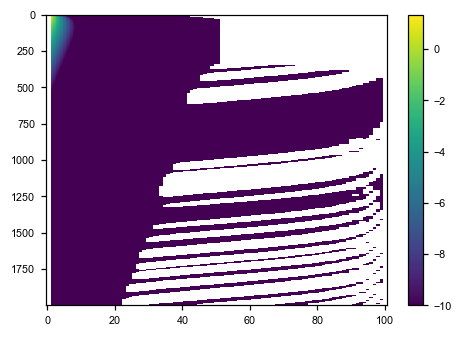

In [1298]:
# -10**sp.optimize.minimize_scalar(get_ll_freqdemchanging,args=({'sfs':sfs,'theta':400,'p_misid':0,'nu':nu_func,'T':4.09},100),).x, -10**sp.optimize.minimize_scalar(get_ll_freqagedemchanging,args=({'sms':SMSmask,'theta':400,'Nc':Nc,'p_misid':0},100),).x
# plt.spy(SMSmask,aspect='auto',color='salmon',markersize=1)

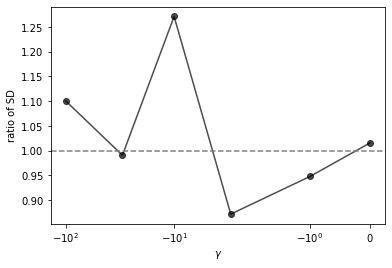

In [7]:
# plt.plot([-50,-0.5,0],np.std(parestfreq,axis=1)/np.std(parestage,axis=1),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--')

# parest = np.loadtxt("outfiles/parestresnotfm10Jan23.txt",delimiter=' ')
parestfreq = parest[:96,0].reshape(6,-1); parestage = parest[:96,1].reshape(6,-1)
plt.plot([-100,-30,-10,-3,-1,0],np.std(parestfreq,axis=1)/np.std(parestage,axis=1),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); 

# gainmom, gainprf = np.array([1.24191538e+00, 1.84289892e+00, 1.30432199e+00, 7.86562111e-01, 7.21972888e-01, 1.29473337e+00, 9.82358160e-12]), np.array([1.022, 1.28412464, 1.089, 1.02163206, 1.112, 1.53472087, 0.947, 0.97024787, 0.880, 0.9260589, 0.875, 0.88787239, 0.851])
# plt.plot([-100,-30,-10,-3,-1,-0.3,0],gainmom,'-o',color='purple',alpha=0.7,label='moments'); 
# plt.plot([-100,-60,-30,-15,-10,-6,-3,-1.5,-1,-0.6,-0.3,-0.15,0],gainprf,'-o',color='green',alpha=0.7,label='PReFerSim')
# plt.xlabel(r'$\gamma$'); plt.ylabel('ratio of SD'); plt.legend(); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); plt.xscale('symlog'); plt.xlim((-120,0.1))

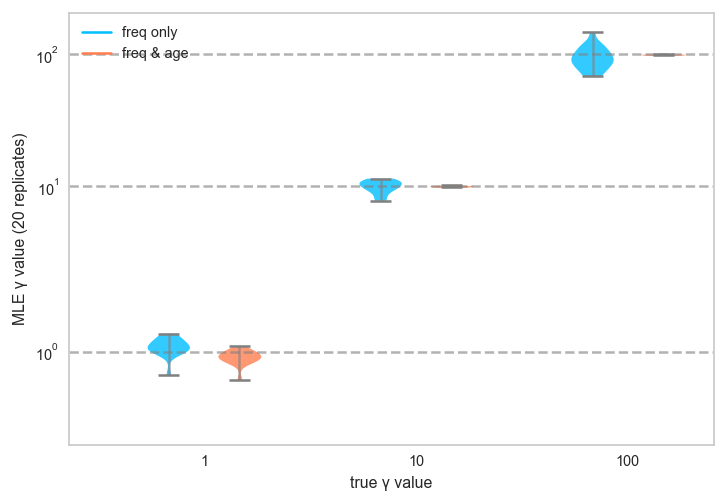

In [69]:
def setViolColors(bp):
    bp['bodies'][0].set_facecolor('deepskyblue')
    bp['bodies'][0].set_alpha(0.8)
    bp['bodies'][0].set_linewidth(1)
    bp['cbars'].set_colors('grey')
    bp['cbars'].set_alpha(0.6)
    bp['cmins'].set_color('grey')
    bp['cmaxes'].set_color('grey')
    # plt.setp(bp['cbars'][0], color='deepskyblue')
    # plt.setp(bp['caps'][1], color='deepskyblue')
    # plt.setp(bp['whiskers'][0], color='deepskyblue')
    # plt.setp(bp['whiskers'][1], color='deepskyblue')
    # plt.setp(bp['fliers'][0], color='deepskyblue')
    # plt.setp(bp['medians'][0], color='deepskyblue')

    plt.setp(bp['bodies'][1], color='coral', alpha=0.8)
    # plt.setp(bp['cbars'][1], color='coral')
    # plt.setp(bp['caps'][3], color='coral')
    # plt.setp(bp['whiskers'][2], color='coral')
    # plt.setp(bp['whiskers'][3], color='coral')
    # plt.setp(bp['fliers'][1], color='coral')
    # plt.setp(bp['medians'][1], color='coral')

fig = plt.figure(dpi=130)
plt.style.use('seaborn-paper')
ax = plt.axes()
s = np.array([1,10,100]) #np.array([-100.,-10.,-1.,0])

for i in range(len(s)):
    # bp = plt.boxplot([parestfreq[i,~np.isnan(parestfreq[i,:])],parestage[i,~np.isnan(parestage[i,:])]],positions=[3*i+1,3*i+2], widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5),)
    # setBoxColors(bp)
    vp = plt.violinplot([parestfreq[i,:],parestage[i,:]],positions=[3*i+1,3*i+2], widths=0.6,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6)

# bp = plt.boxplot([parestfreq0,parestage0],positions=[16,17],widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5))
# setBoxColors(bp) 
# vp = plt.violinplot([-parestfreq[-1,:],-parestage[-1,:]],positions=[9,10],widths=0.6,)
# setViolColors(vp)
# plt.axhline(0.,color='grey',ls='--',alpha=0.6);

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1.5,4.5,7.5,]); ax.set_xticklabels(np.ravel(s.tolist())); ax.set_yscale('symlog'); ax.set_yticks(s); plt.grid()

hB, = plt.plot(0,0,color='deepskyblue'); hR, = plt.plot(0,0,color='coral'); #hB.set_visible(True); hR.set_visible(True)
plt.xlabel('true γ value'); plt.ylabel('MLE γ value (20 replicates)'); plt.legend((hB, hR),('freq only','freq & age'),loc='upper left')
# plt.legend((hB, hR),('freq only, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s[:-1])-np.log10(np.mean(-parestfreq[:-1,:],axis=1)))**2))), 'freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s[:-1])-np.log10(np.mean(-parestage[:-1,:],axis=1)))**2)))),loc='upper left')
# plt.savefig("../figs/MLEfreqage2.pdf")

### Changing demographic history (Tennessen et al 2012) with Boyko DFE parameters
DFE: $\text{Beta}(\alpha=0.2,\beta=200)$

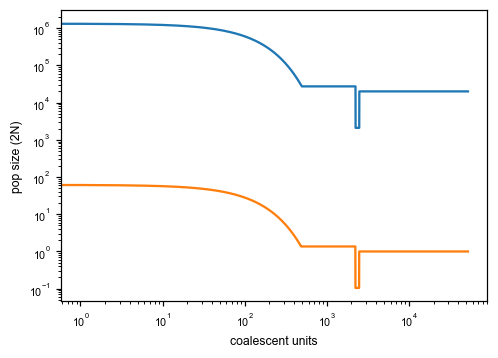

In [1108]:
demo = np.loadtxt("simfiles/1kg_1.5_n10_prefersim_demo.txt", delimiter=" ", dtype='int')
Nc = []
[Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
nu_func = lambda t: [Nc[int(t*20000)]/Nc[0]] # Nc[0] = N = 12378
Nc = np.array(list(it.chain(*Nc)))
plt.plot(Nc[::-1]); plt.loglog(); plt.xlabel('gens ago'); plt.ylabel('pop size (2N)');
plt.plot([nu_func(t) for t in np.linspace(2.624,0,len(Nc))]); plt.loglog(); plt.xlabel('coalescent units'); 

10000.0

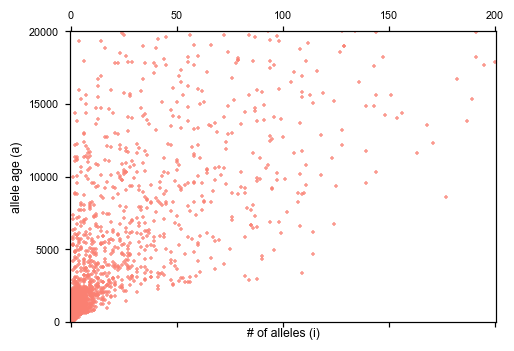

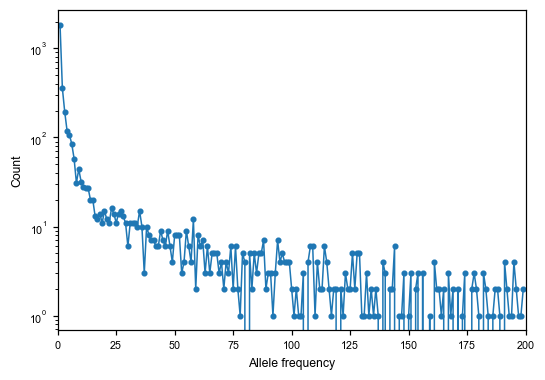

In [ ]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = round(df1['Xl']*200)
# df1 = df1.loc[df1['al']<50000,:]
df1['al'] = len(Nc)+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

SMS = np.zeros((len(Nc),200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,202))[0])
moments.Plotting.plot_1d_fs(sfs)

20000

In [571]:
## creating a database of P(X, a | s) with dicts for different s values
del up_xa_s
up_xa_s = {}
gammas = np.logspace(-3,2,20)
up_xa_s[0] = run_mom_iterate_changing(200, 0, Nc/2, 4, {})
for ig, g in enumerate(gammas):
    fsa = run_mom_iterate_changing(200, -2*g/(Nc[0]/2), Nc/2, 4, {})
    fsa[(fsa<0) | (fsa>10)] = 0
    up_xa_s[g] = fsa
    
# del p_xa_s
p_xa_s = {}
for g in np.append(gammas,0):
    fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-2*g, theta=800)
    fs = moments.Spectrum(fs)
    fs.integrate(nu_func, 2.624, gamma=-2*g, dt_fac=0.001, theta=800)
    fs = fs.project([200])
    fs[(fs<0) | (fs>1000)] = 0
    p_xa_s[g] = fs

N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.99

In [608]:
sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.1,1000]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':len(Nc)},200))
# get_ll_freqagechanging(np.log10([0.2,10]),{'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':len(Nc)},200)
# sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.6,100]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200),bounds=((-2,0),(0,4)))
# get_ll_freqchanging(np.log10([0.2,20]),{'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200)

 final_simplex: (array([[-0.336, 0.968],
       [-0.336, 0.968],
       [-0.336, 0.968]]), array([15771.965, 15771.965, 15771.965]))
           fun: 15771.96484375
       message: 'Optimization terminated successfully.'
          nfev: 110
           nit: 50
        status: 0
       success: True
             x: array([-0.336, 0.968])

In [240]:
# nsims = 16
# estabfr, estabag = np.zeros((nsims,2)), np.zeros((nsims,2))
for n in range(1,nsims):
    os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))

    df1 = pd.read_csv("outfiles/gammaHuber17Unif.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
    df1['sXl'] = round(df1['Xl']*200)
    df1['al'] = 50000+1-df1['al']
    dat = df1.astype('int').to_numpy()

    SMS = np.zeros((50000,200+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(dat)):
        SMS[dat[i,3],dat[i,5]] += 1
    SMSmask = np.ma.array(SMS,mask=mask)

    sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,202))[0])
    
    estabag[n,] = 10**sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.6,10]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':50000,}),bounds=((-2,0),(0,4))).x
    estabfr[n,] = 10**sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.6,10]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,}),bounds=((-2,0),(0,4))).x

    print(estabag[n,],estabfr[n,])
# get_ll_freqchanging(np.log10([0.2,400]),{'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200)
# get_ll_freqagechanging(np.log10([0.8,400]),{'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0},200)

# 10**sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.6,600]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':len(Nc)}),bounds=((-2,0),(0,4))).x, 
# 10**sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,500]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,}),bounds=((-2,0),(0,4))).x

[0.165 334.189] [0.176 281.523]
[0.197 264.138] [0.205 233.719]
[0.188 292.165] [0.201 246.488]
[0.159 532.103] [0.174 402.656]
[0.165 655.958] [0.172 585.744]
[0.203 201.437] [0.196 255.593]
[0.160 480.478] [0.182 327.571]
[0.175 378.110] [0.181 361.668]
[0.161 505.357] [0.177 389.682]
[0.189 292.161] [0.207 226.242]
[0.195 222.061] [0.206 198.459]
[0.181 311.764] [0.190 281.539]
[0.169 429.488] [0.182 355.122]
[0.151 725.878] [0.167 528.811]
[0.182 283.310] [0.190 268.766]


In [ ]:
# plt.scatter(estabfr[:,0],estabfr[:,1],color='deepskyblue',alpha=0.8,label='freq only'); plt.ylabel(r'$\beta$')
# plt.scatter(estabag[:,0],estabag[:,1],color='coral',alpha=0.8,label='freq & age'); plt.plot(0.2,200,'k*',markersize=12,label='true value')
# plt.plot(np.mean(estabfr[:,0]),np.mean(estabfr[:,1]),'*',color='deepskyblue',markersize=15); plt.legend(); plt.xlabel(r'$\alpha$'); 
# plt.plot(np.mean(estabag[:,0]),np.mean(estabag[:,1]),'*',color='coral',markersize=15); plt.grid(); 
estabag.mean(axis=0), estabfr.mean(axis=0)

(array([0.177, 383.025]), array([0.189, 320.219]))

In [38]:
# fsa_est = get_ll_freqageconstant(np.log10(20),{'sms':SMS,'theta':100,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},100)
# fsa_est.shape, fsa.shape, SMS.shape
# SMS[:5,:5], fsa[-5:,:5]
# SMS.nonzero()[0][-10:]
# np.allclose(fsa[:19955,:],fsa_est)
# SMS.sum()*2/sfs.sum()
# fsa.sum()*2/fs.sum()
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':120,'N':10000,'p_misid':0,'gens':10000},200),tol=1e-2,bracket=(-2,3))
# get_ll_freqageconstant(np.log10(20),{'sms':SMSmask,'theta':100,'N':10000,'p_misid':0,'gens':10000},200)

     fun: 33820.174146660334
    nfev: 14
     nit: 10
 success: True
       x: 1.3459852991626884

In [560]:
thetas = np.linspace(1,10,10)
# gtff, ltff = [], []
gtfa, ltfa = [], []
for t in thetas:
    # res = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},250),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
    # ltff.append(res.fun)
    # gtff.append(10**res.x)
    res = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':10000},400))
    ltfa.append(res.fun)
    ## ltfa.append(get_ll_freqageconstant(np.log10(20),{'sms':SMS,'theta':t,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250))
    gtfa.append(10**res.x)

KeyboardInterrupt: 

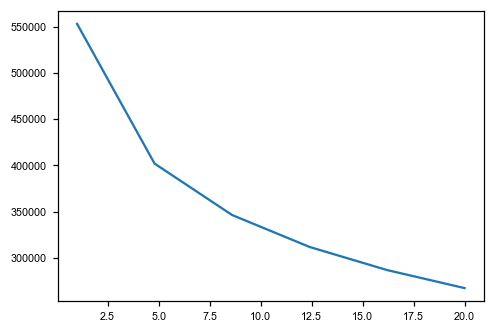

In [581]:
# plt.plot([4,10,20,40,100],[1300,850,470,290,180],'ko',); plt.semilogx(); plt.xlabel(r'$\hat \gamma$'); plt.ylabel(r'$\theta$'); plt.grid(); plt.axhline(100,color='grey',ls='--')
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':100,'N':10000,'p_misid':0},250),tol=1e-2,bracket=(-2,3))
# 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':10000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3)).x 
# np.polyfit(thetas,-np.array(ltfa),2)
# thetas[np.argmin(ltfa)]
plt.plot(np.linspace(1,20,6),[get_ll_freqageconstant(np.log10(20),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':40000},400) for t in np.linspace(1,20,6)])

In [555]:
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':330,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3))
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':120,'p_misid':0},250),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
# plt.scatter(thetas[:4],-np.array(ltff),color='deepskyblue',alpha=0.7,); plt.axvline(100,color='grey'); plt.grid(); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.show()
# plt.scatter(thetas,-np.array(ltfa),color='coral',alpha=0.7,); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.axvline(100,color='grey'); plt.grid(); plt.show()
# plt.scatter(thetas[:4],gtff,color='deepskyblue',alpha=0.8,label='freq only'); plt.axhline(20,color='red'); plt.xlabel(r'$\theta$'); 
# plt.scatter(thetas,gtfa,color='coral',alpha=0.8,label='freq & age'); plt.ylabel(r'$\gamma$'); plt.legend(); plt.grid(); plt.show()

(array([0.100, 0.545, 0.991, 1.436, 1.882, 2.327, 2.773, 3.218, 3.664,
        4.109, 4.555, 5.000]),
 [165210.72552091465,
  124695.93659210317,
  110567.86414550057,
  101857.93498376275,
  95574.9562863296,
  90675.94784506383,
  86672.71811404868])

Text(0, 0.5, 'gens')

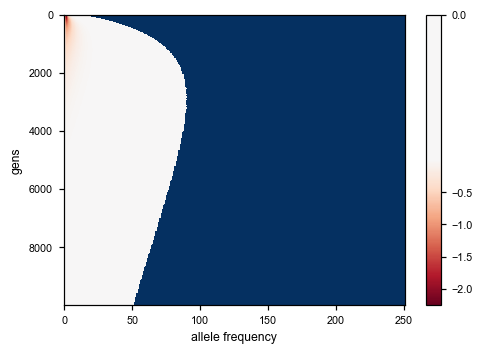

In [121]:
## plot residuals of true and estimated gamma & theta
fst = run_mom_iterate_constant(10000, 250, -100/10000, 10000, 1, {})
# plt.imshow(((fst-fsa)/np.sqrt(fst))[::-1],aspect='auto',cmap='RdBu',norm=colors.TwoSlopeNorm(vcenter=0)); plt.colorbar(); plt.xlabel('allele frequency'); plt.ylabel('gens')
np.sqrt(np.nanmean((np.log(fst+1)-np.log(fsa+1))**2))

In [559]:
## log-lik 2D surface over theta and gamma
# thetas = np.linspace(0.1,5,10)
# gammas = np.logspace(-1,2,10,base=10)
# ll2d = np.zeros((len(thetas),len(gammas)))
# for it, t in enumerate(thetas):
#     for ig, g in enumerate(gammas):
#         ll2d[it,ig] = get_ll_freqageconstant(np.log10(g),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':40000},400)
#         ll2d[it,ig] = get_ll_freqconstant(np.log10(g),{'sfs':sfs,'theta':t,'N':10000,'p_misid':0,},200)

# plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,20,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,20,3),labels=np.round(gammas[::3],1)); 
# plt.axvline(14.7,color='red'); plt.axhline(2.1,color='red'); plt.plot(15,2,'kx')
# np.argwhere(ll2d==np.min(ll2d))

172973.8562246939

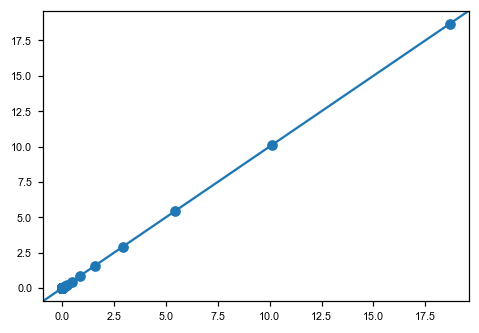

In [30]:
## CODE TO SHOW 1:1 RELATIONSHIP B/W MOMENTS & MY CALCULATIONS

fst = moments.Spectrum(np.zeros(251))
fst[1] = 100
fst.integrate([1], 200/20000, gamma=-13, theta=0)

# plt.scatter(fs,fst); plt.axline((0,0),slope=1); plt.loglog()
# np.allclose(fs,fst)

fsa = run_mom_iterate_constant(2000, 250, -13/10000, 10000, 100, {})

# # moments.Plotting.plot_1d_fs(fs)
plt.scatter(fst,fsa[-200,:]); plt.axline((0,0),slope=1); #plt.loglog()
# np.corrcoef(fst[1:], fsa[-100,1:])
# thetas[4]

In [102]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/ConstantSizeRec10.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = round(df1['Xl']*400)
# df1 = df1.loc[df1['al']<50000,:]
df1['al'] = 80000+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

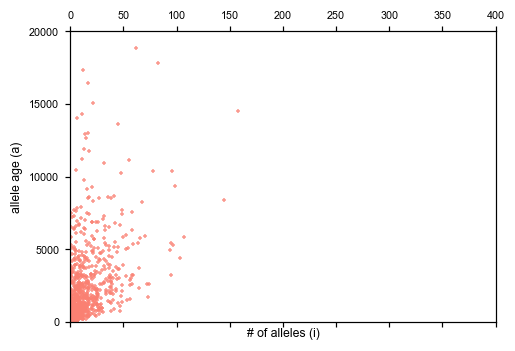

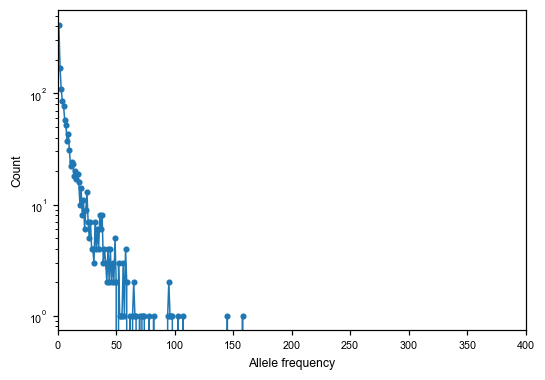

In [109]:
## create a SMS (matrix) instead of SFS
# SMS = np.zeros((80000,400+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(dat)):
#     if (dat[i,3]<80000) & (dat[i,5]<400):
#         SMS[dat[i,3],dat[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

# prfsim = pd.read_csv("outfiles/gammaHuber17Unif.2.sfs_out.txt", sep="\t")
# dadisfs = np.zeros((2000+1,)).astype('int')
# for n in range(0, len(prfsim.columns)-1):
#     dadisfs[int(prfsim.columns[n].split("/")[0])] = int(prfsim.columns[n].split("/")[1])

# f = open("outfiles/ConstantSize6.95.2.dadi.sfs_out.txt", "w")
# f.write("201 unfolded\n")
# f.write(' '.join(map(str, dadisfs)))
# f.close()

# sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,402))[0])
# moments.Plotting.plot_1d_fs(sfs)

# plt.scatter(np.arange(1,172),fs_mis,color='goldenrod',alpha=0.6,label='moments'); plt.scatter(np.arange(1,172),43*sfs[:171],color='purple',alpha=0.4,label='scaled PReFerSim'); 
# plt.xlabel('Allele frequency'); plt.title('SFS with Gamma(0.18,2000) DFE'); plt.legend(); plt.semilogy(); plt.grid()

In [169]:
# get_ll_freqrecconstant([1.8,0.5],{'sfs':sfs,'theta':400,'p_misid':0},200)
# sp.optimize.minimize(get_ll_freqrecconstant,x0=[0.5,0.5],method='Nelder-Mead',args=({'sfs':sfs,'theta':400,'p_misid':0},400),bounds=((-2,3),(0,1)))
# get_ll_freqagerecconstant([1,0.9],{'sms':SMSmask,'N':10000,'theta':400,'gens':40000,'p_misid':0},200)
# sp.optimize.minimize(get_ll_freqagerecconstant,x0=[1,0.25],method='Powell',args=({'sms':SMSmask,'N':10000,'theta':400,'gens':80000,'p_misid':0},400),bounds=((-2,3),(0,1)))
# nsims = 15
# estgamf, estgama = np.zeros((nsims,4)), np.zeros((nsims,4))
# esthf, estha = np.zeros((nsims,4)), np.zeros((nsims,4))
# for ih, h in enumerate([0.1,0.3,0.7,0.9]):
#     fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-20, theta=400, h=h)
#     fs = moments.Spectrum(fs)
#     fs.integrate([1], 3, gamma=-20, theta=400, h=h)
#     fs = fs.project([200]) 
#     fs[fs<0] = -fs[fs<0]

#     fsa = run_mom_iterate_constantrec(40000, 200, -20/10000, 10000, 400, h=h)
#     fsa[fsa<0] = -fsa[fsa<0]
    
#     for n in range(nsims):
#         sfs = np.zeros(len(fs))
#         for i in range(1,len(fs)-1):
#             sfs[i] = rng.poisson(fs[i],1)

#         mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
#         SMS = np.zeros_like(fsa)
#         for i in range(1,SMS.shape[0]):
#             for j in range(1,SMS.shape[1]):
#                 SMS[i,j] = rng.poisson(fsa[-i,j],1)
#         SMSmask = np.ma.array(SMS,mask=mask)  

#         resf = sp.optimize.minimize(get_ll_freqrecconstant,x0=[0.5,0.5],method='Nelder-Mead',args=({'sfs':sfs,'theta':400,'p_misid':0},200),bounds=((-2,3),(0,1))) 
#         estgamf[n,ih] = -10**resf.x[0]; esthf[n,ih] = resf.x[1]

#         resa = sp.optimize.minimize(get_ll_freqagerecconstant,x0=[1,0.25],method='Powell',args=({'sms':SMSmask,'N':10000,'theta':400,'gens':40000,'p_misid':0},200),bounds=((-2,3),(0,1)))
#         estgama[n,ih] = -10**resa.x[0]; estha[n,ih] = resa.x[1]

#     print(estgamf[:,ih].mean(), estgama[:,ih].mean(), esthf[:,ih].mean(), estha[:,ih].mean())

75.15587166176354

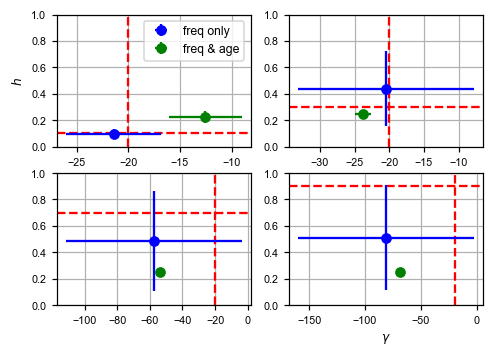

In [160]:
# plt.subplot(2,2,1)
# plt.axhline(0.1,color='red',ls='--'); plt.axvline(-20,color='red',ls='--'); plt.grid(); plt.ylim((0,1))
# plt.errorbar(np.mean(estgamf[:,0]),np.mean(esthf[:,0]),xerr=np.std(estgamf[:,0]),yerr=np.std(esthf[:,0]),fmt='bo',label='freq only'); 
# plt.errorbar(np.mean(estgama[:,0]),np.mean(estha[:,0]),xerr=np.std(estgama[:,0]),yerr=np.std(estha[:,0]),fmt='go',label='freq & age');
# plt.ylabel(r'$h$'); plt.legend()

# plt.subplot(2,2,2)
# plt.axhline(0.3,color='red',ls='--'); plt.axvline(-20,color='red',ls='--'); plt.grid(); plt.ylim((0,1))
# plt.errorbar(np.mean(estgamf[:,1]),np.mean(esthf[:,1]),xerr=np.std(estgamf[:,1]),yerr=np.std(esthf[:,1]),fmt='bo',label='freq only'); 
# plt.errorbar(np.mean(estgama[:,1]),np.mean(estha[:,1]),xerr=np.std(estgama[:,1]),yerr=np.std(estha[:,1]),fmt='go',label='freq & age');

# plt.subplot(2,2,3)
# plt.axhline(0.7,color='red',ls='--'); plt.axvline(-20,color='red',ls='--'); plt.grid(); plt.ylim((0,1))
# plt.errorbar(np.mean(estgamf[:,2]),np.mean(esthf[:,2]),xerr=np.std(estgamf[:,2]),yerr=np.std(esthf[:,2]),fmt='bo',label='freq only'); 
# plt.errorbar(np.mean(estgama[:,2]),np.mean(estha[:,2]),xerr=np.std(estgama[:,2]),yerr=np.std(estha[:,2]),fmt='go',label='freq & age');

# plt.subplot(2,2,4)
# plt.axhline(0.9,color='red',ls='--'); plt.axvline(-20,color='red',ls='--'); plt.grid(); plt.xlabel(r'$\gamma$'); plt.ylim((0,1))
# plt.errorbar(np.mean(estgamf[:,3]),np.mean(esthf[:,3]),xerr=np.std(estgamf[:,3]),yerr=np.std(esthf[:,3]),fmt='bo',label='freq only'); 
# plt.errorbar(np.mean(estgama[:,3]),np.mean(estha[:,3]),xerr=np.std(estgama[:,3]),yerr=np.std(estha[:,3]),fmt='go',label='freq & age');

In [1071]:
num_sims = 10
parestfreq = np.zeros((4,num_sims))
parestage = np.zeros((4,num_sims))
for ig, g in enumerate([-100.,-10.,-1.,0]):
    for n in range(num_sims):
        with open('simfiles/ParameterFilesConstant.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(400)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
        data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

        with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/ConstantSize{}.3.full_out.txt'.format(-g),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*400).astype('int')
        dft['al'] = 80000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        datt = dft.to_numpy()

        SMS = np.zeros((80000,400+1),dtype='int16')
        mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
        for i in range(len(datt)):
            SMS[datt[i,2],datt[i,5]] += 1
        SMSmask = np.ma.array(SMS,mask=mask)

        # sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,402))[0])

        # parestfreq[ig,n] = sp.optimize.minimize_scalar(get_ll_freq, args=(datt[:,5]), options={'xtol': .05,}).x
        # parestage[ig,n] = sp.optimize.minimize_scalar(get_ll_freqage, args=(datt[:,5], datt[:,2]), options={'xtol': .2}).x
        # parestfreq[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},400)).x
        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},400)).x

        # print(parestfreq[ig,n])
        print(parestage[ig,n])

-97.80927785821288
-100.46188861093857
-109.92052818491233
-102.17169665979965
-105.58815750940295
-98.60950119642486
-98.85391898706054
-102.46074476986541
-104.61630785782518
-103.34916472291266
-9.383087044297875
-9.86969885738929
-9.924274828812145
-10.927937128201673
-10.35379204927284
-9.880363361794014
-10.12052626901037
-10.079677734186944
-10.11228890535936
-10.122983374931053
-1.0344285090286083
-0.996189055876628
-0.9962359670933811
-1.023785194929546
-1.140137767520585
-1.0410602792066959
-0.9696687110228885
-0.9258720151385285
-0.9152608500026694
-0.9164569876678964
-0.03344581636588298
-0.051399581980583545
-4.718044825727702e-16
-0.0012457590531624152
-0.0012871876716696827
-0.01807591171300446
-4.718044825727702e-16
-4.718044825727702e-16
-4.718044825727702e-16
-0.059578025645469976


In [1073]:
# parestfreq = np.array([[-106.186, -106.596, -102.536, -91.095, -99.761, -99.894, -100.099, -98.308, -106.185, -104.824],
#         [-10.415, -9.518, -10.463, -10.152, -10.486, -10.314, -10.459, -10.632, -9.297, -10.198],
#         [-1.041, -0.818, -1.082, -0.925, -0.871, -1.048, -1.086, -0.884, -1.125, -1.066],
#         [-0.013, -0.023, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000]])

array([1.293, 1.120, 1.566, 0.340])

In [1067]:
10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},400),).x
# fsa[np.where(fsa.sum(axis=1)<0.2e-2)[0][-1]:,:].shape
# SMSmask.nonzero()[0][-1]
# SMSmask[:5,:5], fsa[-5:,:5]
# get_ll_freqageconstant(np.log10(10),{'sms':SMSmask,'theta':4,'N':10000,'p_misid':0,'gens':50000},400) # 5115.27
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':4,'N':10000,'p_misid':0,'gens':50000},400),)
# np.where(SMSmask[:20000]==0)
# 10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},200),).x
# SMSmask[1:10,1:10]

101.89297573491851

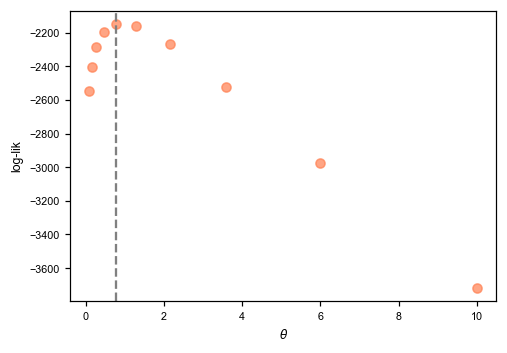

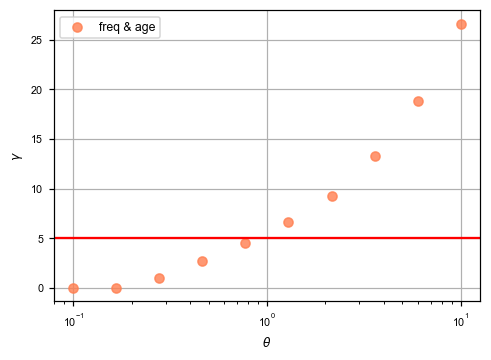

In [341]:
## figuring out the right theta to use for s
thetas = np.logspace(-1,1,10)
# gtff, ltff = [], []
gtfa, ltfa = [], []
for t in thetas:
    # res = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},400),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
    # ltff.append(res.fun)
    # gtff.append(10**res.x)
    res = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':50000},400),tol=1e-2,bracket=(-2,3))
    ltfa.append(res.fun)
    gtfa.append(10**res.x)

# plt.scatter(np.linspace(100,2000,12)[:-1],-np.array(ltff),color='deepskyblue',alpha=0.7,); plt.grid(); plt.xlabel(r'$\theta$'); plt.axvline(np.linspace(100,2000,12)[:-1][np.argmin(ltff)],color='grey',ls='--'); plt.show()
plt.scatter(thetas,-np.array(ltfa),color='coral',alpha=0.7,); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.axvline(thetas[np.argmin(ltfa)],color='grey',ls='--'); plt.show()
# plt.scatter(np.linspace(100,2000,12)[:-1],gtff,color='deepskyblue',alpha=0.8,label='freq only'); plt.axhline(15,color='red'); plt.xlabel(r'$\theta$'); 
plt.scatter(thetas,gtfa,color='coral',alpha=0.8,label='freq & age'); plt.ylabel(r'$\gamma$'); plt.legend(); plt.axhline(5,color='red'); plt.xlabel(r'$\theta$'); plt.grid(); plt.semilogx(); plt.show()
# thetas[np.argmin(ltff)]

In [584]:
## log-lik 2D surface over theta and gamma
thetas = np.logspace(-1,1,12)
gammas = np.logspace(-1,2,12,base=10)
ll2d = np.zeros((len(thetas),len(gammas)))
for it, t in enumerate(thetas):
    for ig, g in enumerate(gammas):
        ll2d[it,ig] = get_ll_freqageconstant(np.log10(g),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':50000},400)

plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,12,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,12,3),labels=np.round(gammas[::3],1)); plt.plot(8,4,'kx'); plt.axvline(8.3,color='red')

# thetas = np.logspace(1,3,12)
# gammas = np.logspace(-1,2,12,base=10)
# ll2d = np.zeros((len(thetas),len(gammas)))
# for it, t in enumerate(thetas):
#     for ig, g in enumerate(gammas):
#         ll2d[it,ig] = get_ll_freqconstant(np.log10(g),{'sfs':sfs,'theta':t,'p_misid':0},400)

# plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,12,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,12,3),labels=np.round(gammas[::3],1)); plt.plot(7,9,'kx'); plt.axvline(8.3,color='red'); plt.axhline(8.7,color='red')

KeyboardInterrupt: 

In [603]:
ll2d[0,:].min(), get_ll_freqageconstant(np.log10(10),{'sms':SMSmask,'theta':1,'N':10000,'p_misid':0,'gens':20000},400)

(1615.3548365482436, 1612.5378727362493)

In [651]:
# np.histogram(df1['gamma'],bins=[0,0.5,5,50,200])[0]/len(df1)
# plt.scatter(np.sort(df1['s']),np.sort(sp.stats.gamma.rvs(0.2,scale=400,size=len(df1))/2000))
# sm.qqplot(df1['s']*20000,sp.stats.distributions.gamma(0.2,scale=400),label=r'simulated (shape=0.2,scale=400)',line='45'); 
# sm.qqplot(sp.stats.gamma.rvs(0.210,scale=2815,size=10000),sp.stats.distributions.gamma(0.18,scale=2000),line='45'); plt.title(r'$\theta=2000$')
# sm.qqplot(sp.stats.gamma.rvs(0.216,scale=5363,size=10000),sp.stats.distributions.gamma(0.18,scale=2000),line='45'); plt.title(r'$\theta=1700$')
# np.mean([sp.stats.ks_2samp(sp.stats.gamma.rvs(0.210,scale=2815,size=10000),sp.stats.gamma.rvs(0.18,scale=2000,size=10000))[0] for _ in range(50)]) # statistic=0.091
# np.mean([sp.stats.ks_2samp(sp.stats.gamma.rvs(0.216,scale=1286,size=10000),sp.stats.gamma.rvs(0.18,scale=2000,size=10000))[0] for _ in range(50)]) # statistic=0.047

0.17421

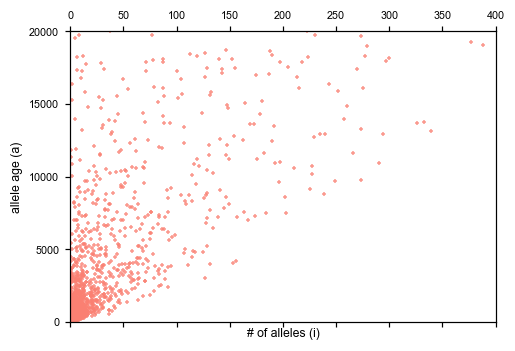

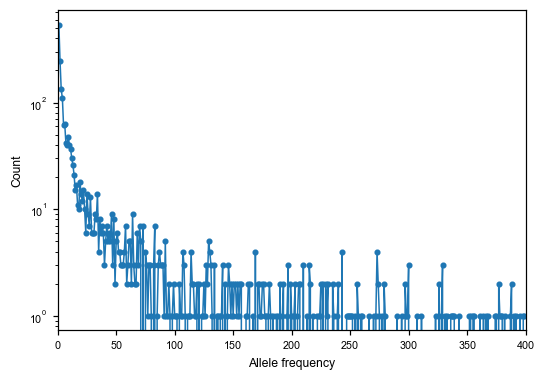

In [56]:
df1 = pd.read_csv("outfiles/gammaHuber17Unif.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = round(df1['Xl']*400)
# df1 = df1.loc[df1['al']<50000,:]
df1['al'] = 50000+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

SMS = np.zeros((50000,400+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,402))[0])
moments.Plotting.plot_1d_fs(sfs)

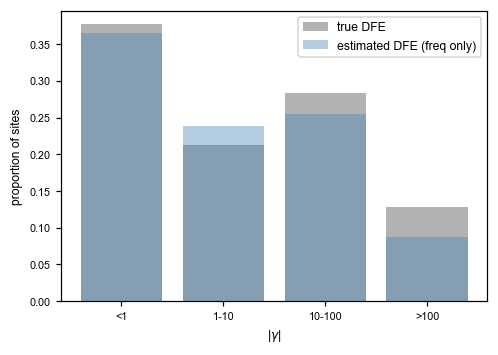

In [259]:
## get simulated distribution of gamma (bins: <1, 1-10, 10-100, >100)
# df1['gamma'] = df1['s']*20000
# plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.6,label=r'observed $\gamma$')
# df1['gamma_inf'] = sp.stats.gamma.rvs(0.174,scale=200,size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf']<1)/len(df1),np.sum((df1['gamma_inf']>1) & (df1['gamma_inf']<10))/len(df1),np.sum((df1['gamma_inf']>10) & (df1['gamma_inf']<100))/len(df1),np.sum(df1['gamma_inf']>100)/len(df1)],color='steelblue',alpha=0.6,label=r'simulated $\gamma$'); plt.legend()
# plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel(r'|$\gamma$|'); plt.ylabel('proportion of sites')

df1['gamma'] = sp.stats.gamma.rvs(0.2,scale=200,size=len(df1)) #df1['s']*20000
plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.6,label=r'true DFE')
df1['gamma_inf'] = sp.stats.gamma.rvs(0.189,scale=320,size=len(df1))
plt.bar(np.arange(4),[np.sum(df1['gamma_inf']<1)/len(df1),np.sum((df1['gamma_inf']>2) & (df1['gamma_inf']<20))/len(df1),np.sum((df1['gamma_inf']>20) & (df1['gamma_inf']<200))/len(df1),np.sum(df1['gamma_inf']>200)/len(df1)],color='steelblue',alpha=0.4,label=r'estimated DFE (freq only)'); 
plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel(r'|$\gamma$|'); plt.ylabel('proportion of sites')
# df1['gamma_inf3'] = sp.stats.gamma.rvs(0.177,scale=383,size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf3']<2)/len(df1),np.sum((df1['gamma_inf3']>1) & (df1['gamma_inf3']<10))/len(df1),np.sum((df1['gamma_inf3']>10) & (df1['gamma_inf3']<100))/len(df1),np.sum(df1['gamma_inf3']>100)/len(df1)],color='salmon',alpha=0.4,label=r'estimated DFE (freq & age)'); 
plt.legend()

In [1191]:
# my_cmap = copy(cm.get_cmap('viridis'))
# my_cmap.set_bad(my_cmap.colors[0])
# Nc = np.linspace(10000,12000,250,dtype='int')
# temp = run_mom_iterate_changing(1000, gamma[-1], Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# temp = run_mom_iterate_constant(len(Nc), 1000, gamma[-1]*0.5/Nc[0], 15000, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# plt.imshow(fsa,aspect='auto',interpolation='nearest',norm=colors.LogNorm(vmin=1e-10),); plt.colorbar()

array([[98210,     1],
       [98210,     2],
       [98210,     3],
       ...,
       [99364,   185],
       [99365,   184],
       [99365,   185]])

In [264]:
## creating a database of P(X, a | s) with dicts for different s values
# n = 200
# cutoff = 1
# del up_xa_s
# gammas = np.logspace(-3,3,15)
# up_xa_s = {}
# up_xa_s[0.0] = run_mom_iterate_constant(50000, 200, 0, 10000, 4, {})
# for ig, g in enumerate(gammas):
#     fsa = run_mom_iterate_constant(50000, 200, -2*g/10000, 10000, 4, {})
#     fsa[(fsa<0) | (fsa>10)] = 0
#     up_xa_s[g] = fsa

# del p_xa_s
p_xa_s = {}
for g in np.append(gammas,0):
    fs = moments.LinearSystem_1D.steady_state_1D(5000, gamma=-2*g)
    fs = moments.Spectrum(fs)
    fs.integrate([1], 3, gamma=-2*g, theta=800) ## for constant stuff 
    fs = fs.project([200])
    fsa[(fsa<0) | (fsa>10)] = 0 
    p_xa_s[g] = fs

In [263]:
sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.5,500]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':50000}),)
# sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.6,100]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200),bounds=((-2,0),(0,4)))
# theta = np.geomspace(1,50000,20)
# lltheta_age = []
# lltheta_freq = []
# for t in theta:
#     lltheta_freq.append(-get_ll_freqchanging(np.log10([0.2,2000]),({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00,'theta':t})))
#     lltheta_age.append(-get_ll_freqagechanging(np.log10([0.2,2000]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMS,'p_misid':0.00,'theta':t})))

# get_ll_freqchanging(np.log10([0.2,200]),({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00})) 
# get_ll_freqagechanging(np.log10([0.1,1700]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0.00,'gens':50000}))

# plt.scatter(theta, lltheta_freq, color='deepskyblue', alpha=0.6, label='freq only'); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); 
# plt.title(r'holding $(\alpha,\beta)$ at MLE'); plt.yscale('symlog'); plt.semilogx(); plt.grid(); plt.axvline(2000,color='k',ls='--',alpha=0.6,label='simulated')
# plt.scatter(theta, lltheta_age, color='coral', alpha=0.6, label='freq & age'); plt.legend(); 

      fun: 415.39229524255825
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.000, 0.000])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 11
     njev: 24
   status: 0
  success: True
        x: array([-0.722, 2.124])

In [408]:
## set up a framework for estimation of gamma for point DFE
## (all this requires is calculating the res for each value of g)
theta = np.geomspace(100,5000,15)
res_t = np.zeros((len(theta),2))
ll_t = np.zeros((len(theta),2))
nzidx = SMS.nonzero()
for it, t in enumerate(theta):
    res_f = np.zeros(len(gammas))
    res_a = np.zeros(len(gammas))
    for ig, g in enumerate(gammas):
        for i in range(1,len(sfs)-1):
            res_f[ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)
        for i in range(len(nzidx[0])):
            res_a[ig] += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)
    ll_t[it,0] = np.nanmax(res_f)
    ll_t[it,1] = np.nanmax(res_a)
    res_t[it,0] = gammas[np.nanargmax(res_f)]
    res_t[it,1] = gammas[np.nanargmax(res_a)]

# theta = np.geomspace(100,1e6,15)
# ll_tf = np.zeros((len(theta),len(gammas)))
# ll_ta = np.zeros((len(theta),len(gammas)))
# nzidx = SMS.nonzero()
# for it, t in enumerate(theta):
#     for ig, g in enumerate(gammas):
#         ll_tf[it,ig] = (-t*p_xa_s[g][:-2] + np.log(t*p_xa_s[g][:-2]) * sfs - sp.special.gammaln(sfs+1)).sum()
#         # for i in range(1,len(sfs)-1):
#         #     ll_tf[it,ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)
#         for i in range(len(nzidx[0])):
#             ll_ta[it,ig] += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)

In [617]:
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':2000,'p_misid':0}),tol=1e-1,bracket=(-2,3))
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':5000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100}),tol=1e-1,bracket=(-2,3))
# get_ll_freqageconstant(np.log10(1e-20),{'sms':SMS,'theta':100,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100})

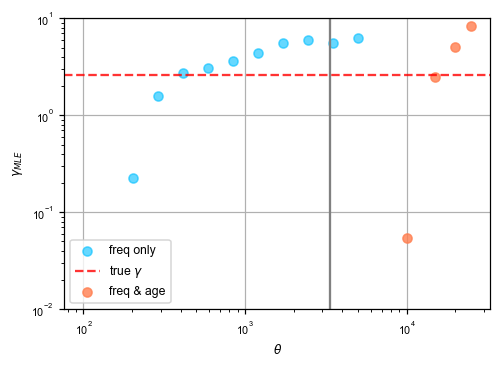

In [626]:
plt.scatter(np.geomspace(100,5000,12),res_t[:,0],alpha=0.6,color='deepskyblue',label='freq only'); plt.axhline(2.64,color='red',ls='--',alpha=0.8,label=r'true $\gamma$'); 
# plt.scatter(theta[ll_t.argmax(axis=0)[0]],res_t[ll_t.argmax(axis=0)[0],0],color='deepskyblue',marker='*',s=200); 
plt.ylim(1e-2,1e1); #plt.xlim(500,1e4)
# plt.scatter(theta[ll_t.argmax(axis=0)[1]],res_t[ll_t.argmax(axis=0)[1],1],color='coral',marker='*',s=200); 
plt.axvline(sfs.sum()*2/p_xa_s[0].sum(),color='grey')
plt.scatter(theta,res_t[:5,1],alpha=0.8,color='coral',label='freq & age'); plt.grid(); plt.loglog(); plt.xlabel(r'$\theta$'); plt.ylabel(r'$\gamma_{MLE}$'); plt.legend(); 

# plt.imshow(ll_tf-np.nanmax(ll_tf),cmap='cividis',vmin=-100); plt.xticks(range(0,len(gammas),3),np.round(gammas[::3],3)); plt.yticks(range(0,len(theta),2),np.round(theta[::2],1));
# plt.show()
# plt.imshow(ll_ta-np.nanmax(ll_ta),cmap='cividis',vmin=-200); plt.xticks(range(0,len(gammas),3),np.round(gammas[::3],3)); plt.yticks(range(0,len(theta),2),np.round(theta[::2],1));

In [201]:
## inference procedure for gamma, but only point DFE (does this work first? Yes, it does!)
nsims = 3
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=3500)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = len(Nc) + 1 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*20000

    dub_onlyfreq, dub_onlyage = np.zeros((len(gamma))), np.zeros((len(gamma))) 
    for ig, g in enumerate(gamma):
        dub_onlyfreq[ig] += np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
        dub_onlyage[ig] += np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))

    mlefreq.append(np.argmax(dub_onlyfreq))
    mleage.append(np.argmax(dub_onlyage))

In [202]:
gamma[mlefreq]*1e5, gamma[mleage]*1e5, -0.00025*1e5
# np.sum(get_lp_alxl(up_xa_s, gamma[-0], dat[:,5], dat[:,3], cutoff=2))

(array([-26.334, -26.334, -26.334]), array([-26.334, -26.334, -18.987]), -25.0)

In [356]:
## code to convert PReFerSim sfs_out file to dadi sfs in file
prfsim = pd.read_csv("outfiles/gammaHuber17Unif.2.sfs_out.txt", sep="\t")
dadisfs = np.zeros((200+1,)).astype('int')
for n in range(0, len(prfsim.columns)-1):
    dadisfs[int(prfsim.columns[n].split("/")[0])] = int(prfsim.columns[n].split("/")[1])

f = open("outfiles/gammaHuber17Unif.2.dadi.sfs_out.txt", "w")
f.write("201 unfolded\n")
f.write(' '.join(map(str, dadisfs)))
f.close()

In [61]:
## fitdadi framework for DFE inference
# sel_params = [0.5, 1000.]
# lower_bound, upper_bound = [1e-3, 1.], [1, 5000.]
# p0 = dadi.Misc.perturb_params(sel_params,lower_bound=lower_bound,upper_bound=upper_bound)
# def DemoTenn12(params, ns, pts):
#     N1,T1,N2,T2,NC,TC, gamma = params
#     xx = dadi.Numerics.default_grid(pts)
#     phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, 0.01, N1, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, T2, N2, gamma=gamma)
#     nu_func = lambda t: N2*np.exp(np.log(NC/N2)*t/TC)
#     phi = dadi.Integration.one_pop(phi, xx, TC, nu_func, gamma=gamma)
#     fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
#     fs[fs < 0] = -fs[fs < 0]
#     return fs
# def DemoConstant(params, ns, pts):
#     N1, gamma = params
#     xx = dadi.Numerics.default_grid(pts)
#     phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, 6, N1, gamma=gamma)
#     fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
#     fs[fs < 0] = -fs[fs < 0]
#     return fs

# spectra = dadi.DFE.Cache1D([0.5], [1000], DemoConstant, pts_l=[1500], gamma_bounds=(1e-3, 500), gamma_pts=20, verbose=True, mp=False)

# popt, llopt = dadi.Inference.opt(p0, data, spectra.integrate, pts=None, func_args=[DFE.PDFs.gamma, 100], lower_bound=lower_bound, upper_bound=upper_bound, verbose=len(sel_params), maxtime=10, multinom=True)
# print(popt, llopt)

# model_sfs = spectra.integrate(popt, None, DFE.PDFs.gamma, 100, None)
# moments.Plotting.plot_1d_fs(model_sfs)

In [842]:
## moments framework for DFE inference
## A couple of outstanding questions:
# 1. what does dxs do? 
# 2. is theta a big deal here?
# 3. increase the number AND range of gamma values
# 4. include pmis...
# WHY IS moments NOT WORKING EITHER??? is the biggest question
data = moments.Spectrum.from_file("outfiles/gammaHuber17Unif.2.dadi.sfs_out.txt")
def selection_spectrum(gamma, h=0.5):
    ns_sim = 10000
    fs = moments.LinearSystem_1D.steady_state_1D(ns_sim, gamma=gamma, h=h)
    ## define the optimal demo parameters here
    fs = moments.Spectrum(fs)
    fs.integrate([0.5], 6, gamma=gamma)
    fs = fs.project([200]) 
    # fs[fs<0] = np.min(np.abs(fs))
    return fs

# spectrum_cache = {}
# spectrum_cache[0] = selection_spectrum(0)

# gammas = np.logspace(-3, 3, 30)
# for gamma in gammas:
#     spectrum_cache[gamma] = selection_spectrum(-gamma)

# p_xa_s = {}
# for g in list(spectrum_cache.keys()):
#     p_xa_s[-g] = spectrum_cache[g]/np.sum(spectrum_cache[g])
#     p_xa_s[-g][p_xa_s[-g]<0] = 1e-250

# dxs = ((gammas - np.concatenate(([gammas[0]], gammas))[:-1]) / 2 + (np.concatenate((gammas, [gammas[-1]]))[1:] - gammas) / 2)

def dfe_func(params, ns, theta=600):
    alpha, beta = params
    fs = spectrum_cache[0] * sp.stats.gamma.cdf(gammas[0], alpha, scale=beta)
    weights = sp.stats.gamma.pdf(gammas, alpha, scale=beta)
    for gamma, dx, w in zip(gammas, dxs, weights):
        fs += spectrum_cache[gamma] * dx * w
    fs = theta * fs
    return fs 

opt_params_mis = moments.Inference.optimize_log_fmin([0.5,1000], data, dfe_func, lower_bound=[1e-3,1], upper_bound=[1,50000], multinom=True, maxiter=200)
print(opt_params_mis, moments.Inference.ll_multinom(dfe_func(opt_params_mis,200,1000),data))

[0.185 49997.302] -402.212477299273


In [91]:
# sp.special.logsumexp(llage,b=wt), np.log(np.sum(wt*np.exp(llfreq)))
# plt.plot(llfreq-llfreq.max()); plt.plot(llage-llage.max()); plt.ylim((-10,0))
# plt.scatter(dat[:,5], dat[:,3])
# a1, b1 = np.log(np.linspace(0.1,0.5,2)), np.linspace(0.4,0.6,2) # -> this is the ~real deal~
# np.log(np.sum(np.exp(a1)*b1)), sp.special.logsumexp(a1,b=b1)
# llfreq, llage
# get_ll_freqchanging(np.log([1,1]),({'p_xa_s':p_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5]}))

array([0.026, 0.062, 0.082, 0.109, 0.146, 0.195, 0.259, 0.346, 0.461,
       0.615, 0.820, 1.094, 1.459, 1.946, 2.595, 3.460, 4.614, 6.153,
       8.205, 10.941, 14.591, 19.457, 25.946, 34.600, 19.773])

In [46]:
# fsa = np.zeros_like(up_xa_s[gamma[-1]])
# fs = np.zeros_like(p_xa_s[gamma[-1]])
# weights = sp.stats.gamma.pdf(-40000*gamma, alpha[1], scale=beta[1])
# for g, dx, w in zip(gamma, dxs, weights):
#     fs += p_xa_s[g] * dx * w
#     fsa += up_xa_s[g] * dx * w

# plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar();  plt.show()
# moments.Plotting.plot_1d_fs(fs)
# get_ll_xl(fs, dat[:,5]), get_ll_xl_al(fsa, dat[:,5], dat[:,2]) 
# get_ll_freqchanging([np.log(0.1),np.log(1000)],{'p_xa_s':p_xa_s,'N0':20000,'gamma':gamma,'sXlred':dat[:,5]})
# get_ll_freqagechanging(np.log([a,b]),({'up_xa_s':up_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5],'alred':dat[:,3]}))
# get_ll_freqagechanging([np.log(0.1),np.log(1000)],{'up_xa_s':up_xa_s,'N0':40000,'gamma':gamma,'sXlred':dat[:,5],'alred':dat[:,3]})

4678018.894154326

In [888]:
## inference procedure basically means integrating over different values of alpha & beta producing a certain gamma using the appropriate prior (Gamma dist)
## implement sth about weighting (dx*wt) the entire SFS instead of just the sum? and then passing it along to the optim func
alpha, beta = np.linspace(0.1,0.3,10), np.linspace(50,1000,10)
nsims = 1; theta=1
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    # df1 = pd.read_csv("outfiles/gammaHuber17Const.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=2000)
    # df1['sXl'] = df1['Xl']*1000
    # df1['al'] = 80000+1 - df1['al']
    # dat = df1.astype('int').to_numpy()

    dub_onlyfreq, dub_onlyage = np.zeros((len(alpha),len(beta))), np.zeros((len(alpha),len(beta))) 
    for ia, a in enumerate(alpha):
        for ib, b in enumerate(beta):
            # dub_onlyfreq[ia,ib] = get_ll_freqchanging(np.log10([a,b]),({'p_xa_s':p_xa_s,'gamma':np.logspace(-3,3,15),'sfs':sfs,'p_misid':0.00})) 
            dub_onlyage[ia,ib] = get_ll_freqagechanging(np.log10([a,b]),({'up_xa_s':up_xa_s,'gamma':np.logspace(-2,3,15),'sms':SMSmask,'p_misid':0.00,'gens':50000}))

    # mlefreq.append(np.unravel_index(np.argmin(dub_onlyfreq,axis=None),dub_onlyfreq.shape))
    mleage.append(np.unravel_index(np.argmin(dub_onlyage,axis=None),dub_onlyage.shape))

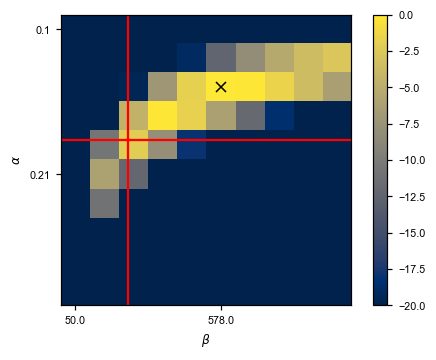

In [917]:
# plt.imshow(dub_onlyfreq-np.nanmax(dub_onlyfreq),vmin=-2); plt.title(r'True value $(\alpha,\beta)=(0.2,400)$'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.show()
# plt.imshow(dub_onlyage-np.max(dub_onlyage),vmin=-10); plt.colorbar(); plt.title(r'True value $(\alpha,\beta)=(0.18,2000)$'); plt.xticks(ticks=range(0,len(beta),3),labels=np.round(beta[::3])); plt.yticks(ticks=range(0,len(beta),3),labels=np.round(alpha[::3],2)); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$')

# plt.imshow(-dub_onlyfreq+np.min(dub_onlyfreq),vmin=-100,cmap='cividis'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.axvline(2.1,color='red'); plt.axhline(1.8,color='red'); plt.plot(mlefreq[0][1],mlefreq[0][0],'kx'); plt.show()
# plt.imshow(-dub_onlyage+np.min(dub_onlyage),vmin=-20,cmap='cividis'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.axvline(1.8,color='red'); plt.axhline(3.8,color='red'); plt.plot(mleage[0][1],mleage[0][0],'kx'); plt.show()

# get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2)
# ?plt.plot

## Calculating the variance from sims and matching to moments expectation 

We are doing this as we found that there is no gain in information when run on PReFerSim data vs from moments data. Why is this? 

1. A reason could be that the variance in each age & freq bin is not equal to the expectation in each bin (i.e., $\mathbb{V}[X_{ia}] \neq \mathbb{E}[X_{ia}]$) **BUT IT IS EQUAL**

2. This could also be investigated by looking at the ECDF of allele ages and comparing to $\frac{\sum_{a'=1}^{a*}F_{ia'}}{\sum_{a'=1}^{\infty}F_{ia'}}$

In [848]:
# df1 = pd.read_csv("outfiles/ConstantSize10.10.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
# ages = np.array(80000+1- df1['al']); freqs = np.array((df1['Xl']*1000).astype('int'))
# df1 = pd.read_csv("outfiles/ConstantSize10.20.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
# ages = np.append(ages,np.array(80000+1- df1['al'])); freqs = np.append(freqs,np.array((df1['Xl']*1000).astype('int')))
# df1 = pd.read_csv("outfiles/ConstantSize10.30.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
# ages = np.append(ages,np.array(80000+1- df1['al'])); freqs = np.append(freqs,np.array((df1['Xl']*1000).astype('int')))
# plt.hist(ages,25)

fsa10 = run_mom_iterate_constant(30000, 10, -10/10000, 10000, 200, {})[::-1] # divide by number of sims
fsa10 = np.pad(fsa10,((1,0),(0,0)))[:-1,:]
# SMS = np.loadtxt('outfiles/SMS_mdw.txt.gz',delimiter=',')
# SMS = SMS.reshape(SMS.shape[0], SMS.shape[1] // 699, 699)
SMSvar = SMS.var(axis=2); SMSmean = SMS.mean(axis=2)

[]

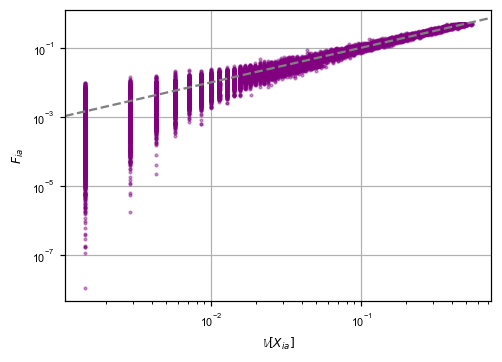

In [910]:
## diff mat b/w exp & var in sims ($X_ia$)
# diffmom = SMSmean - SMSvar
# np.sum(diffmom<0), np.sum(diffmom>0)
# diffmom[diffmom==0] = np.nan
# plt.imshow(SMS[:10000,2:].mean(axis=2),cmap='Greens',aspect='auto'); plt.colorbar(); plt.xticks(range(8),range(2,10)); plt.title(r'$\mathbb{E}[X_{ia}]$')
# plt.imshow(diffmom[:1000,2:],cmap='RdBu',aspect='auto',vmin=-0.01,vmax=0.01); plt.colorbar(); plt.xticks(range(8),range(2,10)); plt.title(r'$\mathbb{E}[X_{ia}] - \mathbb{V}[X_{ia}]$')
# plt.hist(np.ravel(diffmom[:10000,2:]),20); plt.semilogy(); plt.title(r'$\mathbb{E}[X_{ia}] - \mathbb{V}[X_{ia}]$ for $i\geq2$')
# plt.plot(np.ravel(diffmom[:10000,2:]),'ko',alpha=0.3)
# np.sum(diffmom[:10000,2:]<0), np.sum(diffmom[:10000,2:]>0)
# plt.scatter(SMSmean[~np.isnan(diffmom)],SMSvar[~np.isnan(diffmom)],color='k',alpha=0.3,s=10); plt.xlabel(r'$\mathbb{E}[X_{ia}]$'); plt.ylabel(r'$\mathbb{V}[X_{ia}]$'); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.grid(); plt.loglog()
# plt.hist(np.ravel(diffmom),25); plt.semilogy(); plt.title(r'$\mathbb{E}[X_{ia}] - \mathbb{V}[X_{ia}] \forall i$')
# plt.hist(np.ravel(diffmom[:1000,2:]),20); plt.semilogy(); plt.title(r'$\mathbb{E}[X_{ia}] - \mathbb{V}[X_{ia}]$ for $i \geq 2$')
# np.sum(diffmom[:10000,3:]<0), np.sum(diffmom[:10000,3:]>0)

## diff mat b/w var in sims & exp from moments
# diffexp = SMSvar - fsa10
# diffexp[diffmom==0] = np.nan
# plt.hist(np.ravel(diffexp[diffmom!=0]),25); plt.semilogy()
# np.sum(diffexp[diffmom!=0]<0), np.sum(diffexp[diffmom!=0]>0)
# plt.scatter(SMSmean[~np.isnan(diffmom)],fsa10[~np.isnan(diffmom)]/400,color='goldenrod',alpha=0.4,s=3); plt.xlabel(r'$\mathbb{E}[X_{ia}]$'); plt.ylabel(r'$F_{ia}$'); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.grid(); plt.loglog(); plt.show()
plt.scatter(SMSvar[~np.isnan(diffmom)],fsa10[~np.isnan(diffmom)]/400,color='purple',alpha=0.4,s=3); plt.xlabel(r'$\mathbb{V}[X_{ia}]$'); plt.ylabel(r'$F_{ia}$'); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.grid(); plt.loglog()
# plt.imshow(diffexp,cmap='RdBu',aspect='auto',vmin=-0.01,vmax=0.01); plt.colorbar(); plt.title(r'$\mathbb{V}[X_{ia}]-F_{ia}$'); 

In [347]:
## need the same mutation rate and particular frequency bin...
# from statsmodels.distributions.empirical_distribution import ECDF
# fsa10 = run_mom_iterate_constant(50000, 200, -10/10000, 10000, 3, {})[::-1]

# from scipy.stats import rv_discrete
# kst = np.zeros((80,2))
# for i in range(1,80):
#     pk = [fsa10[a,i]/fsa10[:,i].sum() for a in np.arange(1,np.max(ages))]
#     cstm = rv_discrete(name='cstm', values=(np.arange(1,np.max(ages)),pk/np.sum(pk)))
#     if len(ages[freqs==i]>0):
#         kst[i-1,:] = np.ravel(sp.stats.kstest(ages[freqs==i],cstm.rvs(size=10000)))

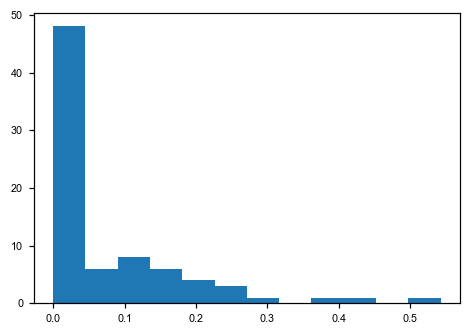

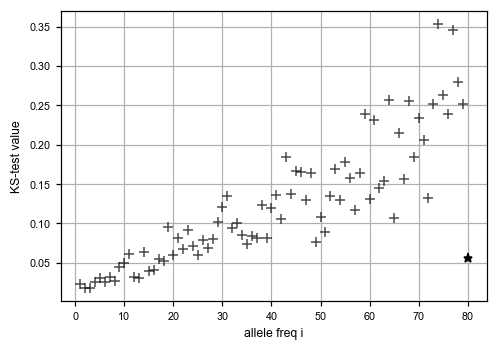

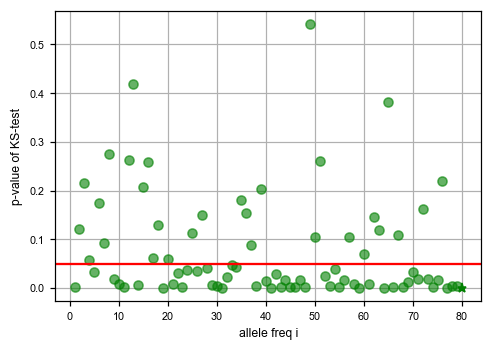

In [64]:
plt.hist(kst[:-1,1],12); plt.show()
plt.plot(range(1,80),kst[:-1,0],'k+',alpha=0.7,); plt.grid(); plt.xlabel('allele freq i'); plt.ylabel('KS-test value'); plt.plot(80,0.056,'k*'); plt.show()
plt.plot(range(1,80),kst[:-1,1],'go',alpha=0.6); plt.grid(); plt.xlabel('allele freq i'); plt.ylabel('p-value of KS-test'); plt.plot(80,3.5e-4,'g*'); plt.axhline(0.05,color='red')

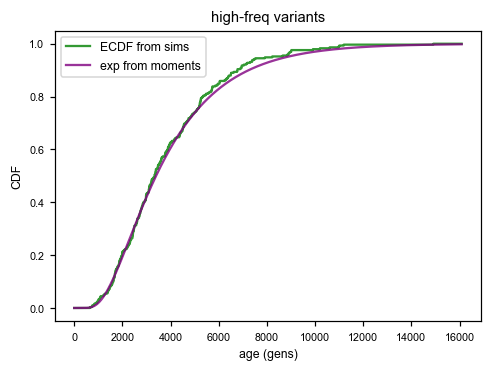

In [152]:
# age_ecdf = ECDF(ages[freqs>=100]); #len(ages[(freqs>=20) & (freqs<=50)]), len(ages[freqs<20]), len(ages[freqs>200])
# totsum = fsa10[:,100:].sum()
# cumsumage = [fsa10[:a,100:].sum()/totsum for a in np.arange(1,np.max(ages))]
plt.plot(np.arange(1,np.max(ages)),[age_ecdf(a) for a in np.arange(1,np.max(ages))],color='green',alpha=0.8,label='ECDF from sims'); plt.plot(np.arange(1,np.max(ages)),cumsumage,color='purple',alpha=0.8,label='exp from moments'); plt.xlabel('age (gens)'); plt.ylabel('CDF'); plt.title('high-freq variants'); plt.legend(); 
# plt.axline((0,0),slope=1,color='grey'); 
# plt.grid(); plt.xlabel(r'$ECDF^{-1}$'); plt.ylabel('cumulative sum of exp.'); plt.title('i >= 100')
# pvals = []
# for i in np.linspace(50,90,15,dtype='int'):
#     totsum = fsa10[:,i:(i+30)].sum() 
#     pk = [fsa10[a,i:(i+30)].sum()/totsum for a in np.arange(1,np.max(ages))]
#     cstm = rv_discrete(name='cstm', values=(np.arange(1,np.max(ages)),pk/np.sum(pk)))
#     pvals.append(sp.stats.kstest(ages[(freqs>=i) & (freqs<(i+30))],cstm.rvs(size=10000))[1])

# import statsmodels
# statsmodels.stats.multitest.multipletests(pvals)

(array([10841.000, 1868.000, 1176.000, 901.000, 761.000, 690.000, 660.000,
        677.000, 777.000, 1649.000]),
 array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000], dtype=float32),
 <BarContainer object of 10 artists>)

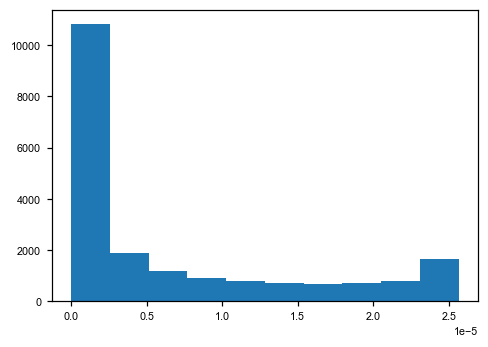

In [433]:
## comparing the mean & variance between the simulations & the expectations Var[X] = E[X^2] - (E[X])^2
# plt.plot(fsa10[:,50]*range(20000),label='i = 50'); plt.axvline(np.sum(fsa10[:,50]*range(20000)),ls='--'); plt.xlabel('ages'); plt.ylabel('PDF')
# plt.plot(fsa10[:,5]*range(20000),label='i = 5',alpha=0.6); plt.axvline(np.sum(fsa10[:,5]*range(20000)),ls='--',color='orange'); plt.legend(); plt.xlim((-1000,25000))

# ageexp = [np.sum(fsa10[:,i]/fsa10[:,i].sum()*range(1,100001)) for i in range(1,200)]
# agemean = [np.mean(ages[freqs==i]) if len(ages[freqs==i])>0 else np.nan for i in range(1,200)]
# plt.plot(range(1,200),ageexp,'go',alpha=0.6,label='moments'); plt.plot(range(1,200),agemean,'o',color='purple',alpha=0.5,label='sims'); plt.legend(); plt.grid(); plt.xlabel('allele freq i'); plt.ylabel('mean age (gens)'); 

# agevar = [np.sum(fsa10[:,i]/fsa10[:,i].sum()*np.arange(1,100001)**2) - agemean[i-1]**2 for i in range(1,200)]
# ageempvar = [np.var(ages[freqs==i]) if len(ages[freqs==i])>0 else np.nan for i in range(1,200)]
# plt.plot(range(1,200),np.sqrt(agevar),'go',alpha=0.6,label='moments'); plt.plot(range(1,200),np.sqrt(ageempvar),'o',color='purple',alpha=0.5,label='sims'); plt.legend(); plt.grid(); plt.xlabel('allele freq i'); plt.ylabel('variance in age'); plt.semilogy()

## New model for likelihood of selection coefficient given ages

$\prod_a \sum_{n=1}^N P(X|q,S) \times P(S|p,n) \times P(n|\frac{\theta}{2})$

_Previous model:_ $\prod_a \prod_i P(X_{ia} | \frac{\theta}{2}F_{ia})$

$F_{ia}$ is assuming we start the diffusion with mutational input of 1. 

In [469]:
# sp.stats.multinomial.logpmf(SMSmask[a,:],tempsum,fsa10[i,a]/fsa10[a,:].sum())
# sp.stats.poisson.pmf(30,theta) * sp.stats.binom.pmf(SMSmask[:,i].sum(),30,probseg)
# sp.stats.multinomial.logpmf()
# fsa10 = run_mom_iterate_constant(SMSmask.shape[0], SMSmask.shape[1]-1, -(10**1)/N, N, 3, {})[::-1]

In [482]:
-0.5*10/10000

-0.0005

In [478]:
num_sims = 10
# parestfreq = np.zeros((4,num_sims))
# parestage = np.zeros((4,num_sims))
# loglikab = np.zeros((num_sims,2,3))
for ig, g in enumerate([-100.,-10.,-1.,0.]):
    if (ig==1) | (ig==2):
        continue 
    for n in range(num_sims):
        with open('simfiles/ParameterFilesConstant.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(400)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
        data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

        with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/ConstantSize{}.3.full_out.txt'.format(-g),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*200).astype('int')
        dft['al'] = 80000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        datt = dft.to_numpy()

        SMS = np.zeros((80000,200+1),dtype='int16')
        mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
        for i in range(len(datt)):
            SMS[datt[i,2],datt[i,5]] += 1
        SMSmask = np.ma.array(SMS,mask=mask)

        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_new_loglik,args=({'theta':3,'SMSmask':SMSmask,'N':8500},200),tol=1e-3).x
        # loglikab[n,:,0] = get_new_loglik(np.log10(5),{'theta':3,'SMSmask':SMSmask,'N':5000},200)
        # loglikab[n,:,1] = get_new_loglik(0,{'theta':3,'SMSmask':SMSmask,'N':5000},200)
        # loglikab[n,:,2] = get_new_loglik(np.log10(0.2),{'theta':3,'SMSmask':SMSmask,'N':5000},200)

        print(parestage[ig,n])

-79.02095025819183
-70.43725376373415
-59.6110717639802
-49.90320483839339
-51.23894415545982
-96.58828311512029
-53.00494681429368
-67.67440008550481
-81.9170549980449
-76.48062902164575
-0.35546239111082956
-0.3579065871111343
-0.1538846565053034
-0.2595444052125074
-0.36483158014181866
-0.13250155514043502
-0.3797150792273616
-0.2914165909704597
-0.45284004390104965
-0.3778947457521079


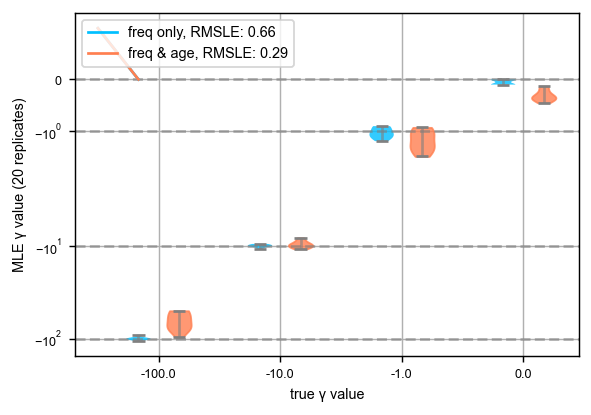

In [481]:
# parestfreq = -np.array([[100.756, 104.793, 104.931, 99.876, 98.784, 90.711, 97.843, 101.897, 100.753, 99.271],
#         [9.616, 9.769, 10.315, 9.405, 10.001, 9.913, 9.895, 9.425, 9.713, 10.653],
#         [1.113, 1.151, 1.204, 0.938, 1.036, 0.911, 1.122, 0.915, 1.026, 1.046],
#         [-4.35832402069063e-45, -4.35832402069063e-45, -4.35832402069063e-45, -4.35832402069063e-45, -4.35832402069063e-45, -1.971976596466917e-15, -1.971976596466917e-15, -1.971975942072855e-15, -4.35832402069063e-45, -4.35832402069063e-45, -4.35832402069063e-45]])

# array([[-79.021, -70.437, -59.611, -49.903, -51.239, -96.588, -53.005, -67.674, -81.917, -76.481],
#        [-10.268, -9.972, -10.607, -9.549, -9.467, -8.065, -9.218, -8.663, -10.167, -9.631],
#        [-1.328, -1.316, -1.100, -0.935, -1.127, -1.019, -1.275, -1.503, -0.950, -1.417],
#        [-0.355, -0.358, -0.154, -0.260, -0.365, -0.133, -0.380, -0.291, -0.453, -0.378]])

def setViolColors(bp):
    bp['bodies'][0].set_facecolor('deepskyblue')
    bp['bodies'][0].set_alpha(0.8)
    bp['bodies'][0].set_linewidth(1)
    bp['cbars'].set_colors('grey')
    bp['cbars'].set_alpha(0.6)
    bp['cmins'].set_color('grey')
    bp['cmaxes'].set_color('grey')
    # plt.setp(bp['cbars'][0], color='deepskyblue')
    # plt.setp(bp['caps'][1], color='deepskyblue')
    # plt.setp(bp['whiskers'][0], color='deepskyblue')
    # plt.setp(bp['whiskers'][1], color='deepskyblue')
    # plt.setp(bp['fliers'][0], color='deepskyblue')
    # plt.setp(bp['medians'][0], color='deepskyblue')

    plt.setp(bp['bodies'][1], color='coral', alpha=0.8)
    # plt.setp(bp['cbars'][1], color='coral')
    # plt.setp(bp['caps'][3], color='coral')
    # plt.setp(bp['whiskers'][2], color='coral')
    # plt.setp(bp['whiskers'][3], color='coral')
    # plt.setp(bp['fliers'][1], color='coral')
    # plt.setp(bp['medians'][1], color='coral')

fig = plt.figure(dpi=130)
ax = plt.axes()
s = np.array([-100.,-10.,-1.,0])
# hold(True)

for i in range(len(s)):
    # bp = plt.boxplot([parestfreq[i,~np.isnan(parestfreq[i,:])],parestage[i,~np.isnan(parestage[i,:])]],positions=[3*i+1,3*i+2], widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5),)
    # setBoxColors(bp)
    vp = plt.violinplot([parestfreq[i,:],parestage[i,:]],positions=[3*i+1,3*i+2], widths=0.6,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6)

# bp = plt.boxplot([parestfreq0,parestage0],positions=[16,17],widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5))
# setBoxColors(bp) 
# vp = plt.violinplot([-parestfreq[-1,:],-parestage[-1,:]],positions=[9,10],widths=0.6,)
# setViolColors(vp)
# plt.axhline(0.,color='grey',ls='--',alpha=0.6);

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1.5,4.5,7.5,10.5]); ax.set_xticklabels(np.ravel(s.tolist())); ax.set_yscale('symlog'); ax.set_yticks([-100.,-10.,-1.,0,]); plt.grid()

hB, = plt.plot([1,0],'-',color='deepskyblue'); hR, = plt.plot([1,0],'-',color='coral'); hB.set_visible(True); hR.set_visible(True)
plt.xlabel('true γ value'); plt.ylabel('MLE γ value (20 replicates)')
plt.legend((hB, hR),('freq only, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.nanmean(-parestfreq,axis=1)))**2))), 'freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.nanmean(-parestage,axis=1)))**2)))),loc='upper left')
# plt.legend((hR),'freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.nanmean(-parestage,axis=1)))**2))),loc='upper left')
# plt.savefig("../figs/MLEfreqage2.pdf")

(array([1513.000, 301.000, 169.000, 106.000, 81.000, 49.000, 37.000,
        37.000, 14.000, 14.000]),
 array([1.0, 7934.3, 15867.6, 23800.9, 31734.2, 39667.5, 47600.8, 55534.1,
        63467.4, 71400.7, 79334.0], dtype=object),
 <BarContainer object of 10 artists>)

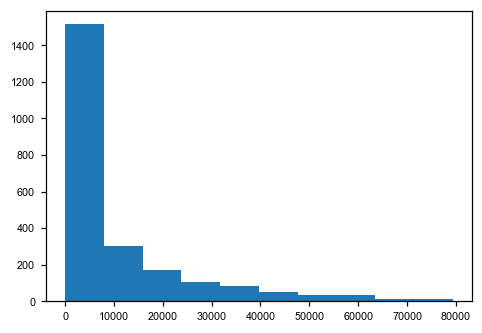

In [486]:
# parestage

In [463]:
opts={'theta':3,'SMSmask':SMSmask,'N':10000}
# nll = [get_new_loglik(g, opts, 200) for g in np.linspace(-1,2,12)]; np.argmin(nll)
sp.optimize.minimize_scalar(get_new_loglik,args=(opts,200),tol=1e-3)
# get_new_loglik(np.log10(23), opts, 200)
# nll = [get_ll_freqageconstant(g, {'sms':SMSmask,'theta':3,'N':10000,'p_misid':0,'gens':20000},200) for g in np.linspace(-1,2,12)]; np.argmin(nll)
# plt.plot(np.geomspace(1,100,10),[-get_new_loglik(np.log10(10), {'theta':t,'SMSmask':SMSmask,'N':5000}, 200) for t in np.geomspace(1,100,10)],'ko'); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.semilogx(); plt.axvline(6,color='red',ls='--')
# plt.plot(np.geomspace(1,100,10),[10**sp.optimize.minimize_scalar(get_new_loglik,args=({'theta':t,'SMSmask':SMSmask,'N':5000},200),tol=1e-3).x for t in np.geomspace(1,100,10)], 'ko'); plt.xlabel(r'$\theta$'); plt.ylabel(r'$\hat \gamma$'); plt.semilogx(); plt.axhline(10,color='red')

# plt.plot(np.geomspace(2000,20000,12,dtype='int'),[-get_new_loglik(np.log10(10), {'theta':6,'SMSmask':SMSmask,'N':N}, 200) for N in np.geomspace(2000,20000,12,dtype='int')],'ko'); plt.xlabel('N'); plt.ylabel('log-lik'); plt.semilogx(); 
# plt.plot(np.geomspace(2000,20000,10,dtype='int'),[10**sp.optimize.minimize_scalar(get_new_loglik,args=({'theta':6,'SMSmask':SMSmask,'N':N},200),tol=1e-3).x for N in np.geomspace(2000,20000,10,dtype='int')], 'ko'); plt.xlabel('N'); plt.ylabel(r'$\hat \gamma$'); plt.semilogx(); #plt.axhline(10,color='red')

     fun: 5756.0221307169195
    nfev: 14
     nit: 9
 success: True
       x: -0.5641940263181346

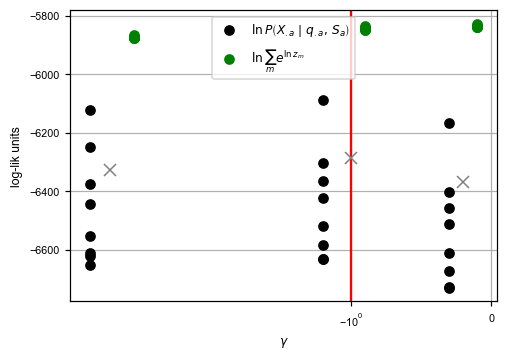

In [392]:
## gamma = -100
# plt.scatter(np.repeat(-195,8),loglikab[:,0,0],color='k',label=r'$\ln P\left(X_{.a}\mid q_{.a},\,S_{a}\right)$'); plt.scatter(np.repeat(-205,8),loglikab[:,1,0]-200,color='g'); 
# plt.scatter(np.repeat(-95,8),loglikab[:,0,1],color='k'); plt.scatter(np.repeat(-105,8),loglikab[:,1,1]-200,color='g',label=r'$\ln\sum_{m}^{}e^{\ln z_{m}}$')
# plt.scatter(np.repeat(-51,8),loglikab[:,0,2],color='k'); plt.scatter(np.repeat(-49,8),loglikab[:,1,2]-200,color='g')
# plt.xlabel(r'$\gamma$'); plt.ylabel('log-lik units'); plt.axvline(-100,color='red'); plt.xscale('symlog'); plt.grid()
# plt.plot([-200,-100,-50],loglikab[:,:,:].mean(axis=0).sum(axis=0),'x',color='grey',markersize=8); plt.legend()

## gamma = -10
# plt.scatter(np.repeat(-45,8),loglikab[:,0,0],color='k',label=r'$\ln P\left(X_{.a}\mid q_{.a},\,S_{a}\right)$'); plt.scatter(np.repeat(-55,8),loglikab[:,1,0]-2000,color='g'); 
# plt.scatter(np.repeat(-8,8),loglikab[:,0,1],color='k'); plt.scatter(np.repeat(-12,8),loglikab[:,1,1]-2000,color='g',label=r'$\ln\sum_{m}^{}e^{\ln z_{m}}$')
# plt.scatter(np.repeat(-1.8,8),loglikab[:,0,2],color='k'); plt.scatter(np.repeat(-2.5,8),loglikab[:,1,2]-2000,color='g')
# plt.xlabel(r'$\gamma$'); plt.ylabel('log-lik units'); plt.axvline(-10,color='red'); plt.xscale('symlog'); plt.grid()
# plt.plot([-50,-10,-2],loglikab[:,:,:].mean(axis=0).sum(axis=0),'x',color='grey',markersize=8); plt.legend()

## gamma = -1
plt.scatter(np.repeat(-6,8),loglikab[:,0,0],color='k',label=r'$\ln P\left(X_{.a}\mid q_{.a},\,S_{a}\right)$'); plt.scatter(np.repeat(-4,8),loglikab[:,1,0]-6000,color='g'); 
plt.scatter(np.repeat(-1.2,8),loglikab[:,0,1],color='k'); plt.scatter(np.repeat(-0.9,8),loglikab[:,1,1]-6000,color='g',label=r'$\ln\sum_{m}^{}e^{\ln z_{m}}$')
plt.scatter(np.repeat(-.3,8),loglikab[:,0,2],color='k'); plt.scatter(np.repeat(-.1,8),loglikab[:,1,2]-6000,color='g')
plt.xlabel(r'$\gamma$'); plt.ylabel('log-lik units'); plt.axvline(-1,color='red'); plt.xscale('symlog'); plt.grid()
plt.plot([-5,-1,-0.2],loglikab[:,:,:].mean(axis=0).sum(axis=0),'x',color='grey',markersize=8); plt.legend()

In [406]:
loglikab[:,1,2]

array([160.612, 162.919, 161.327, 173.429, 163.683, 165.481, 166.758,
       166.663])

In [225]:
loglikb = 0
for a in np.where(opts['SMSmask'].sum(axis=1)>0)[0]:
    S = opts['SMSmask'][a,:].sum()
    probseg = fsa10[a,:].sum()/opts['theta']
    lb = int(sp.stats.poisson.ppf(0.01,opts['theta']/2)); ub = int(sp.stats.poisson.ppf(0.99,opts['theta']/2))
    tempsum = np.zeros(ub-lb+1)
    for idn, n in enumerate(range(lb,ub)):
        tempsum[idn] = sp.stats.poisson._logpmf(n,opts['theta']) + sp.stats.binom._logpmf(S,n,probseg)# sp.special.gammaln(n+1) - sp.special.gammaln(n-x+1) + (n-x)*np.log(1-probseg)
    loglikb += sp.special.logsumexp(tempsum)
# plt.plot(np.where(SMSmask.sum(axis=1)>0)[0],[sp.stats.multinomial._logpmf(SMSmask[a,:],SMSmask[a,:].sum(),fsa10[a,:]/fsa10[a,:].sum()) for a in np.where(SMSmask.sum(axis=1)>0)[0]],'k.',alpha=0.6); plt.ylabel('Multinom logpmf'); plt.grid(); plt.xlabel('ages in gens');

In [335]:
sp.special.logsumexp(tempsum), logsumexp(tempsum)

(0.021941894805056213, 0.021941894805056213)

In [467]:
def get_new_loglik(g, opts, n=200):
    fsa10 = run_mom_iterate_constant(opts['SMSmask'].shape[0], opts['SMSmask'].shape[1]-1, -(10**g)/opts['N'], opts['N'], opts['theta'], {})[::-1]

    loglika = 0; loglikb = 0
    lb = int(sp.stats.poisson.ppf(0.01,opts['theta'])); ub = int(sp.stats.poisson.ppf(0.99,opts['theta']))
    
    for a in np.where(opts['SMSmask'].sum(axis=1)>0)[0]:
        S = opts['SMSmask'][a,:].sum()
        loglika += sp.stats.multinomial._logpmf(opts['SMSmask'][a,:],S,fsa10[a,:]/fsa10[a,:].sum())

        probseg = fsa10[a,:].sum()/opts['theta']
        
        tempsum = np.zeros(ub-lb+1)
        # tempsum += x*np.log(probseg) - sp.special.gammaln(x+1)
        for idn, n in enumerate(range(lb,ub)):
            tempsum[idn] = sp.stats.poisson._logpmf(n,opts['theta']) + sp.stats.binom._logpmf(S,n,probseg)# sp.special.gammaln(n+1) - sp.special.gammaln(n-x+1) + (n-x)*np.log(1-probseg)
        loglikb += sp.special.logsumexp(tempsum)

    return -(loglika+loglikb)

## Computing posterior distribution for selection coefficient at a single site

$g(\gamma_l | X_l) \propto P(\gamma_l | X_l) = \frac{P(X_l | \gamma_l) P (\gamma_l)}{P(X_l)} \newline$

$\gamma_l \sim \text{Unif}(0.1,200)$, which is just the DFE of new mutations in my simulations

$ P(X_l|\gamma_l) = \frac{\mathcal{L}(\gamma_l; X_l)}{\sum_i^{2n} \mathcal{L}(\gamma_l; X_i)}$, which is just the likelihood of seeing a variant at a certain frequency and a certain selection coefficient *conditional* on segregation

Note: $\theta$ needs to figure in here somewhere, just don't know where

Sampling of posterior can be done with Metropolis-Hastings (can use code borrowed from here: https://python4mpia.github.io/fitting_data/Metropolis-Hastings.html)

$\gamma_n \sim \mathcal{N}(\gamma_o, \sigma^2)$, where $\sigma^2$ is the proposal standard deviation

Acceptance ratio: 
$\rho = \frac{g(\gamma_n | X_l)}{g(\gamma_o | X_l)}$, and accept $\gamma_n$ with probability $\rho$. Set $\gamma_o = \gamma_n$ and propose a new value from the symmetrical normal distribution.  

In [106]:
## function for computing the likelihood x prior for a specific s/gamma from the prior (do ~2000 draws from a uniform dist for gamma (?) and then normalize)
# sp.stats.gamma.rvs(0.2,scale=200,size=10)
# fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-10, theta=40,)
# fs = moments.Spectrum(fs)
# fs.integrate([1], 3, gamma=-10, theta=40) ## for PReFerSim, we need 0.5Ne instead of Ne
# fs = fs.project([200]) 
# fs[fs<0] = -fs[fs<0]

# loglik = -fs[10] + np.log(fs[10]) * 26 - sp.special.gammaln(26+1)
# prior = sp.stats.uniform.logpdf(100,loc=1,scale=1000) # sp.stats.gamma.logpdf(20,0.2,scale=200)

def run_MH_parallel(gini):
    return get_post_gammaMH(gini,1,40000,400,20,)

finalres20 = Parallel(n_jobs=3)(delayed(run_MH_parallel)(x) for x in [0.5,1.,1.5]) # tempres20

Step 1000...
Step 1000...
Step 1000...
Step 2000...
Step 2000...
Step 2000...
Step 3000...
Step 3000...
Step 3000...
Step 4000...
Step 4000...
Step 5000...
Step 5000...
Step 4000...
Step 6000...
Step 6000...
Step 7000...
Step 5000...
Step 7000...
Step 8000...
Step 6000...
Step 8000...
Step 9000...
Step 9000...
Step 7000...
Step 10000...
Step 10000...
Step 11000...
Step 8000...
Step 11000...
Step 12000...
Step 9000...
Step 12000...
Step 13000...
Step 13000...
Step 14000...
Step 10000...
Step 14000...
Step 15000...
Step 11000...
Step 16000...
Step 15000...
Step 12000...
Step 17000...
Step 16000...
Step 18000...
Step 17000...
Step 13000...
Step 19000...
Step 18000...
Step 20000...
Step 14000...
Step 19000...
Step 21000...
Step 20000...
Step 15000...
Step 22000...
Step 23000...
Step 21000...
Step 16000...
Step 24000...
Step 22000...
Step 25000...
Step 23000...
Step 17000...
Step 26000...
Step 24000...
Step 18000...
Step 27000...
Step 25000...
Step 28000...
Step 19000...
Step 29000...
Step 

0.6833333333333333 0.553 0.5033333333333333


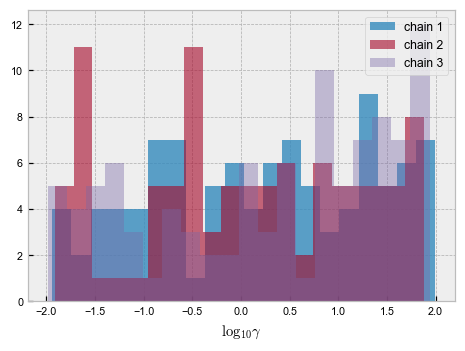

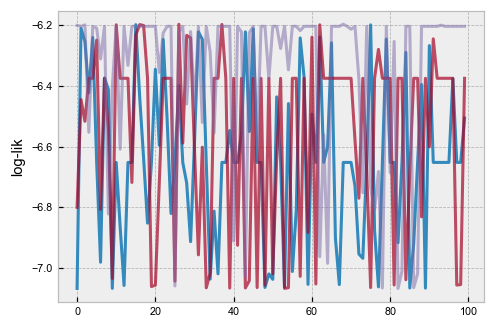

In [102]:
burnin = 1500; thin = 15
print(finalres2[0][2]/len(finalres2[0][0]),finalres2[1][2]/len(finalres2[0][0]),finalres2[2][2]/len(finalres2[0][0]))
plt.hist(np.log10(finalres2[0][0][burnin::thin]),20,alpha=.8,label='chain 1'); plt.hist(np.log10(finalres2[1][0][burnin::thin]),20,alpha=.6,label='chain 2'); plt.hist(np.log10(finalres2[2][0][burnin::thin]),20,alpha=0.4,label='chain 3'); plt.legend(); plt.xlabel(r'$\log_{10} \gamma$'); plt.show()
# plt.hist(np.log10(finalres2[0][0][burnin::thin]),20,alpha=.8,label='chain 1'); plt.hist(np.log10(sp.stats.gamma.rvs(0.2,scale=200,size=1000)),20,alpha=0.4)
plt.plot(finalres2[0][1][burnin::thin]); plt.plot(finalres2[1][1][burnin::thin],alpha=0.7); plt.plot(finalres2[2][1][burnin::thin],alpha=0.5); plt.ylabel('log-lik'); 
# plt.hist(finalres2[0][0][500::15]); plt.hist(finalres2[1][0][500::15],alpha=0.4);plt.hist(finalres2[2][0][500::15],alpha=0.4) 
# plt.hist(np.random.normal(0.8,0.5,200))

0.7196 0.744 0.77415


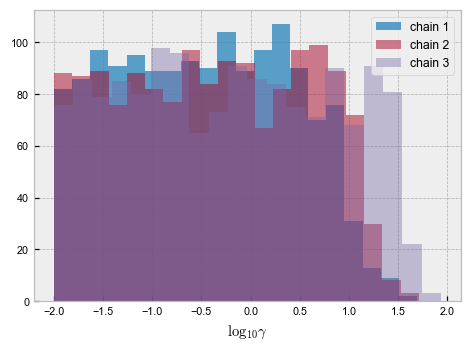

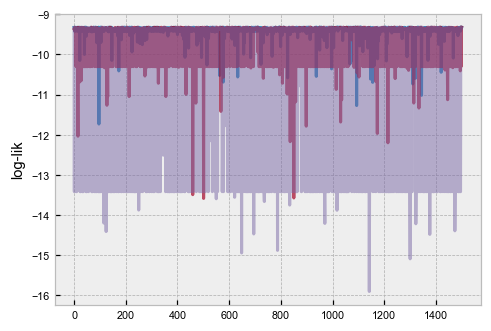

In [107]:
burnin = 25000; thin = 10
print(finalres20[0][2]/len(finalres20[0][0]),finalres20[1][2]/len(finalres20[0][0]),finalres20[2][2]/len(finalres20[0][0]))
# plt.hist(np.append(finalres2[0][0],finalres2[1][0]),20)
plt.hist(np.log10(finalres20[0][0][burnin::thin]),20,alpha=.8,label='chain 1',); plt.hist(np.log10(finalres20[1][0][burnin::thin]),20,alpha=.5,label='chain 2'); plt.hist(np.log10(finalres20[2][0][burnin::thin]),20,alpha=0.4,label='chain 3'); plt.legend(); plt.xlabel(r'$\log_{10} \gamma$'); plt.show()
plt.plot(finalres20[0][1][burnin::thin]); plt.plot(finalres20[1][1][burnin::thin],alpha=0.7); plt.plot(finalres20[2][1][burnin::thin],alpha=0.5); plt.ylabel('log-lik'); 

(array([2693.000, 2720.000, 2663.000, 2663.000, 2608.000, 2528.000,
        2574.000, 2574.000, 2600.000, 2607.000, 2642.000, 2561.000,
        2537.000, 2202.000, 1724.000, 1076.000, 624.000, 275.000, 80.000,
        49.000]),
 array([-1.000, -0.868, -0.736, -0.604, -0.472, -0.340, -0.208, -0.076,
        0.056, 0.188, 0.320, 0.452, 0.584, 0.716, 0.848, 0.980, 1.112,
        1.244, 1.376, 1.508, 1.640]),
 <BarContainer object of 20 artists>)

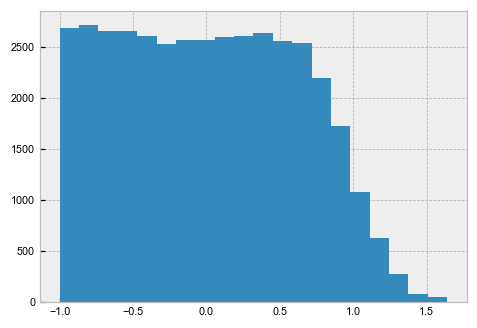

In [97]:
plt.hist(np.log10(np.append(finalres20[0][0],finalres20[1][0])),20)

In [13]:
# plt.hist(np.log10(finalres20[1][0][burnin::thin]),20,alpha=0.6); plt.hist(np.log10(finalres2[1][0][burnin::thin]),20,alpha=0.4)
# plt.plot(finalres20[0][0][burnin::thin]); plt.plot(finalres20[2][0][burnin::thin]); plt.yscale('log')
# import pymc as pm; from mom_functions import *
# logl = LogLike(my_lpf_pymc, 400, 5)
# post_model = pm.Model()
# with post_model:

#     # Priors for unknown model parameter
#     gamma_p = pm.Gamma("gamma", alpha=0.2, beta=1/200) ## rate (beta) = 1/scale

#     gamma = at.as_tensor_variable([gamma_p])

#     lik = pm.Potential("lik", logl(gamma))

#     idata_mh = pm.sample(3000, tune=1000)

# ## plot the traces
# az.plot_trace(idata_mh, lines=[("gamma")])

In [14]:
# # define a aesara Op for our likelihood function
# import aesara.tensor as at
# import arviz as az
# class LogLike(at.Op):

#     """
#     Specify what type of object will be passed and returned to the Op when it is
#     called. In our case we will be passing it a vector of values (the parameters
#     that define our model) and returning a single "scalar" value (the
#     log-likelihood)
#     """

#     itypes = [at.dvector]  # expects a vector of parameter values when called
#     otypes = [at.dscalar]  # outputs a single scalar value (the log likelihood)

#     def __init__(self, loglik, data, x,):
#         """
#         Initialise the Op with various things that our log-likelihood function
#         requires. Below are the things that are needed in this particular
#         example.

#         Parameters
#         ----------
#         loglike:
#             The log-likelihood (or whatever) function we've defined
#         data:
#             The "observed" data that our log-likelihood function takes in
#         x:
#             The dependent variable (aka 'x') that our model requires
#         sigma:
#             The noise standard deviation that our function requires.
#         """

#         # add inputs as class attributes
#         self.likelihood = loglik
#         self.data = data
#         self.x = x

#     def perform(self, node, inputs, outputs):
#         # the method that is used when calling the Op
#         (gamma,) = inputs  # this will contain my variables

#         # call the log-likelihood function
#         logl = self.likelihood(gamma, self.x, self.data)

#         outputs[0][0] = np.array(logl)  # output the log-likelihood